# Reading Particles + Application to Halo detection with Yt/hop and Halo mass function

Better documentation of the functions in my_hmf_cmf_lib.py


## Libraries

In this notebook we will :
* upload a Dyablo Particle file
* interface with Yt
* create a Halo Catalog, using HOP
* plot the volumic distribution of halo masses in the Universe (aka halo mass function HMF) and compare it to some reference (Meriot & Semelin 2024)
* do the same but in a smaller region of the Universe defined by its overdensity (aka conditionnal mass function CMF)

In [7]:
import numpy as np
import h5py
import yt
import matplotlib.pyplot as plt
import sys, platform, os
from CosmoUtils import *
from yt.extensions.astro_analysis.halo_analysis import HaloCatalog
from tqdm import tqdm
import matplotlib.cm as cm

In [8]:
plt.style.use('stylesheet.mplstyle')

In [9]:
import my_hmf_cmf_lib as mycmf

In [10]:
print(mycmf.TCMB)

2.7255


## Upload Particle file

Let's have a first look at the simulation by plotting the dark matter particles

In [11]:
corr_iter_z = [("0000000", 26.1272),
 ("0000250", 2.47551),
 ("0000500", 1.65828),
 ("0000750", 1.30188),
 ("0001000", 1.04726),
 ("0001250", 0.841156),
 ("0001500", 0.660872),
 ("0001750", 0.509201),
 ("0002000", 0.360715),
 ("0002250", 0.24084),
 ("0002500", 0.140594),
 ("0002750", 0.0389838),
 ("0002850", 0.0)]


nb_iter, zsnap = corr_iter_z[-1]

filename = f"cosmo_particles_particles_iter{nb_iter}.h5"

fpart = h5py.File(f'datastageM2/{filename}', 'r')

positions = np.array(fpart['coordinates'])
print(np.shape(positions))

x=positions[:,0]
y=positions[:,1]
z=positions[:,2]
Npart=np.size(x)


# Uncomment if velocities are available in the Dyablo output
#vx = np.array(fpart['vx'])
#vy = np.array(fpart['vy'])
#vz = np.array(fpart['vz'])

(16777216, 3)


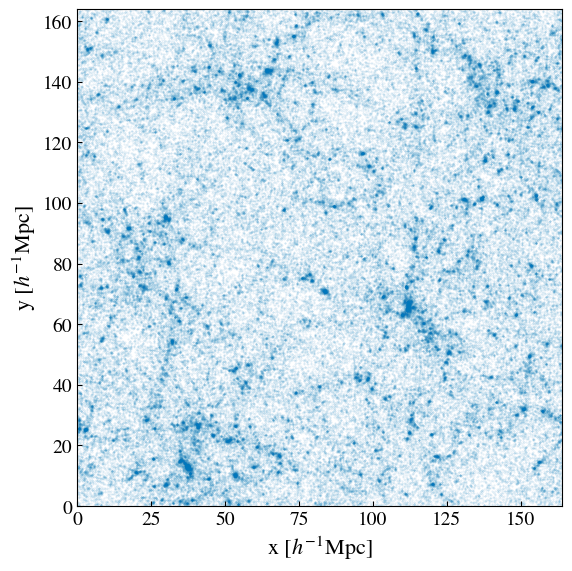

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(x[::100]*164, y[::100]*164, alpha=0.13, s=0.15, rasterized=True)
plt.xlabel("x [$h^{-1}$Mpc]")
plt.ylabel("y [$h^{-1}$Mpc]")
plt.xlim(0,164)
plt.ylim(0,164)
plt.tight_layout()
# plt.savefig(f"./saved_results/misc/particles_{nb_iter}.pdf", dpi=300)
plt.show()

### Some run parameters

In [27]:
L=164 #Mpc/h
H0org=67.00 # km/s/Mpc
om=0.3175 # total density parameter

# Computing the Particle Mass
H0=H0org*1e3/3.086e22
h=H0org/100.
rhoc=3*H0**2/(8*np.pi*6.67e-11) #kg/m^3
rho0 = rhoc * om
mpart=rho0*(L/h*3.086e22)**3/Npart #kg 
mpart_sun = mpart/2e30
print('particle mass [Solar Mass] = {:e}'.format(mpart_sun))

particle mass [Solar Mass] = 3.440346e+10


In [28]:
grid_size = [L/h, L/h, L/h]

In [29]:
print(f"mean density : {rho0:.2e} kg/m^3")

mean density : 2.68e-27 kg/m^3


In [30]:
rho_MsunMpc3 = rho0 / 2e30 * 3.086e22**3 #Msun/Mpc^3
print(f"mean density : {rho_MsunMpc3:.2e} Msun/Mpc^3")

mean density : 3.94e+10 Msun/Mpc^3


## Interfacing with Yt

In [31]:
masses=np.ones(Npart) # dummy particle masses array as a set of unit masses
idx=np.arange(Npart) # monotonic indexes for particles

data = dict(
    particle_position_x=x,
    particle_position_y=y,
    particle_position_z=z,
    particle_velocity_x=x,#dummy with no vel
    particle_velocity_y=y,#dummy with no vel
    particle_velocity_z=z,#dummy with no vel
    particle_mass=masses,
    particle_index=idx
)
ds = yt.load_particles(data,length_unit=L*3.086e24,periodicity=(True,True,True),mass_unit=mpart*1e3)

yt : [INFO     ] 2025-07-08 13:31:45,120 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-08 13:31:45,122 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-07-08 13:31:45,123 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-08 13:31:45,125 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-08 13:31:45,126 Parameters: cosmological_simulation   = 0


## Hop launch (halo finder)

#### Catalog Creation using Hop via Yt

VERY LONG !

In [32]:
# hc = HaloCatalog(data_ds=ds, finder_method="hop",output_dir="./datastageM2/")

In [33]:
# hc.create() # launch in background

In [34]:
fhalo = h5py.File('datastageM2/ParticleData/ParticleData.0.h5', 'r') # upload Hop results

fhalo = h5py.File(f'saved_results/ParticleData/ParticleData{nb_iter}.h5', 'r') # upload Hop results
# fhalo = h5py.File(f'datastageM2/cosmo_iter0000250.h5', 'r') # upload Hop results

In [35]:
fhalo.keys()

<KeysViewHDF5 ['particle_identifier', 'particle_index_start', 'particle_mass', 'particle_number', 'particle_position_x', 'particle_position_y', 'particle_position_z', 'particle_velocity_x', 'particle_velocity_y', 'particle_velocity_z', 'particles', 'virial_radius']>

In [36]:
xh=np.array(fhalo['particle_position_x']) #HOP halo positions
yh=np.array(fhalo['particle_position_y']) #HOP halo positions
zh=np.array(fhalo['particle_position_z']) #HOP halo positions
mh=np.array(fhalo['particle_mass']) #HOP halo mass

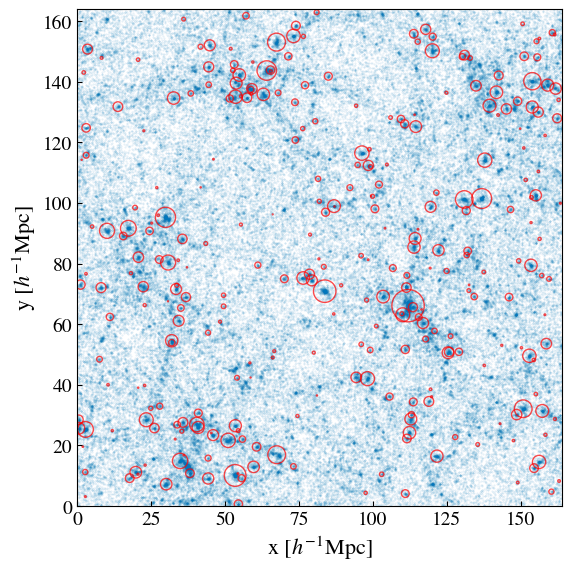

In [ ]:
num_points = 450 # number of halos that we'll show, arbitrary
indices = np.unique(np.logspace(0, np.log10(len(xh)-1), num=num_points, dtype=int))

size_mh_full = mh[indices] / mh[0] * 700

plt.figure(figsize=(6,6))
plt.scatter(x[::100]*164, y[::100]*164, alpha=0.13, s=0.15, rasterized=True)
plt.scatter(xh[indices]*164, yh[indices]*164, 
            alpha=0.7, 
            s=size_mh_full,
            color="red",
            facecolors='none',
            rasterized=True)

plt.xlabel("x [$h^{-1}$Mpc]")
plt.ylabel("y [$h^{-1}$Mpc]")
plt.xlim(0,164)
plt.ylim(0,164)
plt.tight_layout()
plt.savefig(f"./saved_results/misc/halos_{nb_iter}.pdf", dpi=300)
plt.show()

In [39]:
print(len(xh), "halos in the whole domain")

7084 halos in the whole domain


In [42]:
np.round(mh/mpart_sun,0)

array([6.8607e+04, 5.3095e+04, 2.5690e+04, ..., 3.5000e+01, 3.5000e+01,
       3.5000e+01])

# Mass functions

## HMF

Let's first import the HMF library which will tell us if our computations are correct

In [44]:
from hmf import MassFunction

In [45]:
## Mass distriubtion Fit/model from litterature 
# Note that we assume that Initial conditions parameters matches with the MassFunction parameters
hmf = MassFunction(z=zsnap,Mmin=8,hmf_model="ST") # using the ST (Sheth et al. 2001) model which better fits the data
dndm=hmf.dndm # differential halo mass distribution

/home/mesquita/.local/lib/python3.10/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


Creating a power spectrum using our cosmological model and computing the HMF for the ST model

In [46]:
pars,results,s8_fid = mycmf.compute_init_power_spectrum(zsnap, H0org, mycmf.TCMB, om, mycmf.ob, h, mycmf.ns, mycmf.As)

Note: redshifts have been re-sorted (earliest first)


In [47]:
M_list = np.logspace(8,15,1000) #Msun/h

In [48]:
#compute the power spectrum for a given redshift
kh, _, pk = mycmf.compute_matter_power_spectrum(zsnap, pars, s8_fid)
#computing the HMF for the ST model
n_ST_list = [mycmf.hmfcalc(M_list[i], kh, pk, "ST") for i in range(len(M_list))]

Note: redshifts have been re-sorted (earliest first)


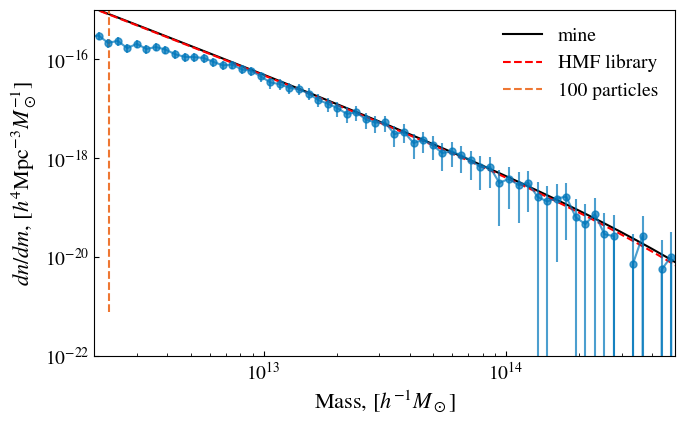

In [51]:
# Plot the reference HMF
plt.figure()
plt.plot(M_list, n_ST_list, color="k", label = "mine")
plt.plot(hmf.m,hmf.dndm, '--', color="red", label="HMF library")
plt.yscale('log')
plt.xscale('log')

###### We compute the histogram of the halo mass for our simulation
bins_hmf=np.logspace(11,16,num=128)
bcen_hmf=0.5*(bins_hmf[1:]+bins_hmf[:-1])
db_hmf=bins_hmf[1:]-bins_hmf[:-1]
# Halo mass function using Hop mass estimate, note that masses must be given in Msol/h
# Note : hop mass is slightly underestimated compared to proper M200 calculation
myhmf,bmf=np.histogram(mh*h,bins=bins_hmf) #<<< msol/h

mydndm_hmf=myhmf/db_hmf/L**3
mydndm1_hmf=mydndm_hmf+3*np.sqrt(myhmf)/db_hmf/L**3 #3 sigma dispersion
mydndm2_hmf=mydndm_hmf-3*np.sqrt(myhmf)/db_hmf/L**3 #3 sigma dispersion


# Plot
# plt.plot(bcen_hmf,mydndm_hmf,'-o',markersize=5,label='hop 256^3 {:5.2f} Mpc/h z={:5.2f}'.format(L,zsnap),alpha=0.3)
# plt.fill_between(bcen_hmf,mydndm1_hmf,mydndm2_hmf,alpha=0.3)

plt.errorbar(bcen_hmf, mydndm_hmf,
    yerr = [mydndm_hmf - mydndm2_hmf,
    mydndm1_hmf - mydndm_hmf],
    fmt='o-', markersize=5, alpha=0.7)

plt.xlabel(r"Mass, $[h^{-1}M_\odot]$")
plt.ylabel(r"$dn/dm$, $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$");
plt.xlim([2e12,5e14])
plt.ylim([1e-22,1e-15])
plt.plot(np.ones(10)*100*mpart*h/2e30,np.linspace(np.min(hmf.dndm),np.max(hmf.dndm),10),'--', label="100 particles")
plt.legend()

## CMF

Our first goal will be to find the number of particles inside a given region

In [ ]:
def norm2dist(norm_val, grid_size):
    '''
    Computes the distance in Mpc from a normalized value between 0 and 1
    
    Inputs :
    norm_val : Normalized value between 0 and 1
    grid_size : Size of the grid in Mpc in each direction (should be the same
    in all directions)
    
    Outputs : 
    dist : Distance in Mpc corresponding to the normalized value
    '''
    for i in range(len(grid_size)-1):
        if grid_size[i]!=grid_size[i+1]:
            print("The grid is does not have the same size in all directions.")
            return -1
    dist = norm_val * grid_size[0]
    return dist

def dist2norm(dist, grid_size):
    '''
    Computes the distance in Mpc from a normalized value between 0 and 1
    
    Inputs :
    dist : Distance in Mpc corresponding to the normalized value
    grid_size : Size of the grid in Mpc in each direction (should be the same
    in all directions)
    
    Outputs : 
    norm_val : Normalized value between 0 and 1
    '''
    for i in range(len(grid_size)-1):
        if grid_size[i]!=grid_size[i+1]:
            print("The grid is does not have the same size in all directions.")
            return -1
    norm_val = dist / grid_size[0]
    return norm_val

In [33]:
x_mpc = norm2dist(x, grid_size)
y_mpc = norm2dist(y, grid_size)
z_mpc = norm2dist(z, grid_size)
part_pos_mpc = np.column_stack((x_mpc, y_mpc, z_mpc))

xh_mpc = norm2dist(xh, grid_size)
yh_mpc = norm2dist(yh, grid_size)
zh_mpc = norm2dist(zh, grid_size)
halo_pos_mpc = np.column_stack((xh_mpc, yh_mpc, zh_mpc))

In [ ]:
def idx_of_part_in_shape(center_sphere, size, grid_size, pos_mpc, shape="sphere"):
    """
    center_sphere : tuple of (cx, cy, cz) in Mpc
    size : radius (for sphere) or half-width (for cube) in Mpc
    grid_size : list of [xsize, ysize, zsize] in Mpc
    pos_mpc : positions of particles in Mpc, shape (N, 3)
    shape : "sphere" or "cube"
    Returns the indices of particles that are inside the specified shape
    """
    cx, cy, cz = center_sphere
    x, y, z = pos_mpc[:,0], pos_mpc[:,1], pos_mpc[:,2]
    xsize, ysize, zsize = grid_size
    
    dx = np.minimum(abs(x - cx), xsize - abs(x - cx)) #either normal distance or substracting the grid_size 
    dy = np.minimum(abs(y - cy), ysize - abs(y - cy))
    dz = np.minimum(abs(z - cz), zsize - abs(z - cz))
    
    if shape == "sphere":
        d = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
        w = np.where(d < size) 
    elif shape == "cube":
        inside_x = dx < size
        inside_y = dy < size
        inside_z = dz < size
        w = np.where(inside_x & inside_y & inside_z)  
    else :
        print("Choose 'sphere' or 'cube' in the shape arg.")
    return np.array(w[0])

We can also use KDTree which does it using probably better methods

Before using KDTree, we need to take into account the periodicity of the domain since KDTree doesn't take it into account directly.

Let's center the domain, on our sphere of choice.

In [35]:
def shift_to_sphere_center(sphere_center, grid_size, points):
    '''
    points = [(x1,y1,z1), (x2,y2,z2), ...]
    '''
    nx, ny, nz = grid_size
    x, y, z = sphere_center
    
    xc, yc, zc = nx / 2, ny / 2, nz / 2 #domain center
    dx, dy, dz = xc - x, yc - y, zc - z
    
    shifted_points = np.array([( (X + dx) % nx, (Y + dy) % ny, (Z + dz) % nz ) for X, Y, Z in points])
    
    return shifted_points

Making a more general function for later (one method might be faster than the other)

In [36]:
from scipy.spatial import KDTree

def idx_halos(center_sphere, radius_sphere, grid_size, halo_pos_mpc, method="Manual", shape="sphere"):
    if method == "KDTree":
        #computing the shifted postion such tha tthe sphere is at the center
        shifted_halos_to_sphere = shift_to_sphere_center(center_sphere, grid_size, halo_pos_mpc)
        
        #creating instances of KDTrees to use their methods
        tree_halo = KDTree(shifted_halos_to_sphere)
        
        nx,ny,nz = grid_size
        shifted_center_sphere = [nx / 2, ny / 2, nz / 2] #new center in the center of the box
        
        #finding the number of halos in the sphere using query_ball_point 
        idx_of_halos_in_sphere_kdtree = np.array(tree_halo.query_ball_point(shifted_center_sphere,radius_sphere))
        
        return idx_of_halos_in_sphere_kdtree
    elif method == "Manual":
        #idx of halos and particles in the sphere respectively
        w_halos = idx_of_part_in_shape(center_sphere, radius_sphere, grid_size, halo_pos_mpc, shape=shape)
        
        return w_halos
    else : 
        print(r"Method not recognized ! Choose between 'KDTree' and 'Manual'.")
        return -1

In [37]:
def sphere_density(Rsphere, nb_part, mpart):
    '''
    Rsphere in Mpc
    rho_sphere in Msun/Mpc^3
    '''
    Msphere = mpart / 2e30 * nb_part #in Msun
    Vsphere = 4/3*np.pi*Rsphere**3 #in Mpc**3
    rho_sphere = Msphere / Vsphere #Msun/Mpc**3
    return rho_sphere

def density_in_shape(center_sphere, size_shape, grid_size, part_pos_mpc, mpart, shape="sphere"):
    w_part = idx_of_part_in_shape(center_sphere, size_shape, grid_size, part_pos_mpc, shape=shape)
    nb_part_in_shape = len(w_part)
    if shape == "sphere":
        rho_shape = sphere_density(size_shape, nb_part_in_shape, mpart)
    elif shape == "cube":
        rho_shape = mpart/2e30 * nb_part_in_shape / (2*size_shape)**3
    else :
        print("Choose 'sphere' or 'cube' in the shape arg.")
    return rho_shape

In [38]:
def paving_domain(N, grid_size):
    nx, ny, nz = grid_size
    dx, dy, dz = nx / N, ny / N, nz / N  # diameter  in each coordinate
    radius = min(dx, dy, dz) / 2  # min to not have spheres that overlap

    i, j, k = np.meshgrid(np.arange(0,N,1), np.arange(0,N,1), np.arange(0,N,1), indexing='ij')

    centers = np.stack(((i+0.5) * dx, (j+0.5) * dy, (k+0.5) * dz), axis=-1) #+0.5 at each i j k?

    centers = np.reshape(centers, (-1,3))
    
    return centers, radius

# Subregion class

In [39]:
class subregion:
    def __init__(self, center, radius, shape="sphere"):
        self.center = np.array(center)
        self.radius = radius #radius for sphere / half_width for cube
        self.shape = shape #sphere or cube
        self.density = None #Msun/Mpc^3
        self.delta_NL = None
        self.delta_L = None # = delta0
        self.part_indices = []
        self.halo_indices = []
        self.num_halos = 0
        self.cmf_emp = None
        self.err_emp = None
        self.bcen_emp = None
        self.cmf_th_cST = None
        self.cmf_th_EPS = None
        self.bins_emp = None
    
    def get_idx_particles_inside(self, part_pos_mpc):
        cx, cy, cz = self.center
        if self.shape == "cube":
            w = np.where((part_pos_mpc[:, 0] >= cx - self.radius) & (part_pos_mpc[:, 0] < cx + self.radius) &
                         (part_pos_mpc[:, 1] >= cy - self.radius) & (part_pos_mpc[:, 1] < cy + self.radius) &
                         (part_pos_mpc[:, 2] >= cz - self.radius) & (part_pos_mpc[:, 2] < cz + self.radius))[0]
        elif self.shape=="sphere": 
            distances = np.sqrt((part_pos_mpc[:, 0] - cx) ** 2 +(part_pos_mpc[:, 1] - cy) ** 2 +(part_pos_mpc[:, 2] - cz) ** 2)
            # distances = np.linalg.norm(part_pos_mpc - self.center, axis=1)
            w = np.where(distances <= self.radius)[0]
        self.part_indices = w
        return w
    
    def compute_density(self, part_pos_mpc, mpart, rho_mean):
        w = self.get_idx_particles_inside(part_pos_mpc)
        num_particles = len(w)
        
        if self.shape == "sphere":
            self.density = sphere_density(self.radius, num_particles, mpart)
        elif self.shape == "cube" : 
            self.density = (mpart / 2e30) * num_particles / (2 * self.radius) ** 3
        
        self.delta_NL = (self.density - rho_mean) / rho_mean
        self.delta_L = mycmf.compute_delta_linear(self.delta_NL)
        
        return num_particles, w
    
    def compute_halo_stat(self, halo_pos_mpc, mh, kh, pk, M_list, grid_size, model = "both", nbins=20):
        self.halo_indices = idx_halos(self.center, self.radius, grid_size, halo_pos_mpc, method="Manual", shape=self.shape)
        self.num_halos = len(self.halo_indices)
        
        if self.num_halos > 0:
            mh_in_subreg = mh[self.halo_indices]
            lightest_halo = np.min(mh_in_subreg)
            heaviest_halo = np.max(mh_in_subreg)
            
            # self.bins_emp = np.logspace(np.log10(lightest_halo), np.log10(heaviest_halo), num=int(np.sqrt(self.num_halos)))
            # self.bins_emp = np.logspace(np.log10(lightest_halo), np.log10(heaviest_halo), num=50)
            self.bins_emp = np.logspace(11, 16, num=nbins)
            
            self.bcen_emp = 0.5 * (self.bins_emp[1:] + self.bins_emp[:-1])
            db = self.bins_emp[1:] - self.bins_emp[:-1]
            cmf, _ = np.histogram(mh_in_subreg * h, bins=self.bins_emp)
            if self.shape == "sphere":
                # Vshape = 4/3 * np.pi * (self.radius * h * (1+self.delta_NL)**(1/3)) ** 3 # (Mpc/h)^3
                Vshape = 4/3 * np.pi * (self.radius * h ) ** 3 # (Mpc/h)^3
            else :
                Vshape = (self.radius * h * (1+self.delta_NL)**(1/3)) ** 3 # (Mpc/h)^3
            
            self.cmf_emp = cmf / db / Vshape
            
            err_upper = self.cmf_emp + 3 * np.sqrt(cmf) / db / Vshape
            err_lower = self.cmf_emp - 3 * np.sqrt(cmf) / db / Vshape
            self.err_emp = [err_upper, err_lower]
        else:
            self.bins_emp = None
            self.bcen_emp = None
            self.cmf_emp = None
            self.err_emp = None
        
        if model == "QcST" :
            self.cmf_th_cST = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, self.delta_NL, "QcST") for i in range(len(M_list))]   
        elif model == "cST" :
            self.cmf_th_cST = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, self.delta_NL, "cST") for i in range(len(M_list))]
        elif model == "QEPS_scaled" :
            self.cmf_th_EPS = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, self.delta_NL, "QEPS_scaled") for i in range(len(M_list))]
        elif model == "EPS" :
            self.cmf_th_EPS = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, "EPS") for i in range(len(M_list))]     
        elif model == "QEPS" :
            self.cmf_th_EPS = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, "QEPS") for i in range(len(M_list))]
        elif model == "EPS_scaled":
            self.cmf_th_EPS = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, "QEPS_scaled") for i in range(len(M_list))]
        else : 
            # self.cmf_th_cST = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, "cST") for i in range(len(M_list))]
            # self.cmf_th_EPS = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, "EPS_scaled") for i in range(len(M_list))]
            self.cmf_th_cST = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, self.delta_NL, "QcST") for i in range(len(M_list))]
            self.cmf_th_EPS = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, self.delta_NL, "QEPS") for i in range(len(M_list))]


In [40]:
def analyze_subregions(Ncut, shape, grid_size, halo_pos_mpc, part_pos_mpc, mpart, rho_mean, mh, kh, pk, M_list, model = "QcST", nbins=20):
    paved_centers, paved_radius = paving_domain(Ncut, grid_size)
    subregions = [subregion(center, paved_radius, shape = shape) for center in paved_centers]
    
    print(f"Computing values for {len(subregions)} spheres of radius {paved_radius:.2f} Mpc...")
    current_nb_part_tot = 0
    current_nb_halos = 0
    for current_subregion in tqdm(subregions):
        num_particles, w = current_subregion.compute_density(part_pos_mpc, mpart, rho_mean)
        part_pos_mpc = np.delete(part_pos_mpc, w, axis=0)  # remove found elements to speed up next iterations
        current_nb_part_tot += num_particles
        current_subregion.compute_halo_stat(halo_pos_mpc, mh, kh, pk, M_list, grid_size, model = model, nbins=nbins)
        current_nb_halos += current_subregion.num_halos
        
    
    print(f"Found {current_nb_part_tot} particles and {current_nb_halos} halos in {Ncut}^3 = {len(subregions)} {shape}s of radius/half-width {paved_radius:.2f} Mpc.")
    return np.array(subregions)

# Parameters to choose and simulation

In [41]:
Ncut = 8
shape="sphere"
nbins = 50
M_list = np.logspace(11,16,200) #Msun/h

subreg_list = analyze_subregions(Ncut, shape ,grid_size, halo_pos_mpc, part_pos_mpc, mpart, rho_MsunMpc3, mh, kh, pk, M_list, model = "cST", nbins=nbins)

Computing values for 512 spheres of radius 15.30 Mpc...


  0%|          | 0/512 [00:00<?, ?it/s]/home/mesquita/stage/my_hmf_cmf_lib.py:329: RuntimeWarning: invalid value encountered in double_scalars
  fourth_term = sig_camb/delta_sig**(3/2)
 29%|██▉       | 149/512 [06:44<05:16,  1.15it/s]/home/mesquita/stage/my_hmf_cmf_lib.py:332: RuntimeWarning: overflow encountered in exp
  fifth_term = np.exp(exp_argument)
100%|██████████| 512/512 [11:12<00:00,  1.31s/it]

Found 8934278 particles and 3729 halos in 8^3 = 512 spheres of radius/half-width 15.30 Mpc.


In [42]:
delta_NL_paved = [subregion.delta_NL for subregion in subreg_list]
idx_sort_delta_NL = np.argsort(delta_NL_paved)
subreg_sorted = subreg_list[idx_sort_delta_NL]

radius_sr = subreg_sorted[0].radius
delta_NL_paved = [subregion.delta_NL for subregion in subreg_sorted]

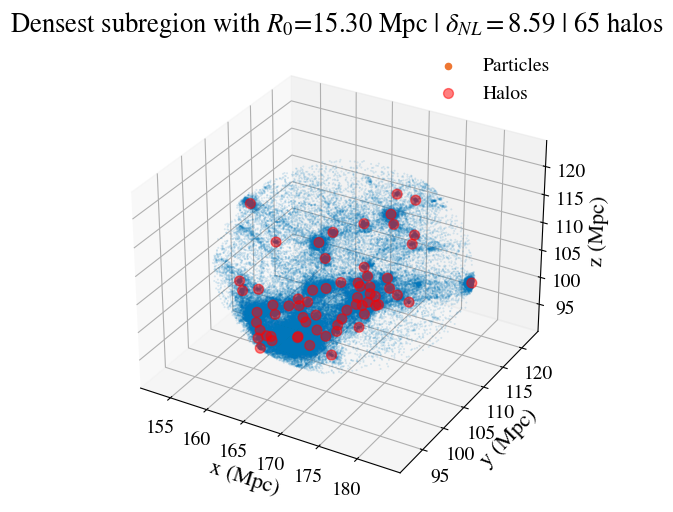

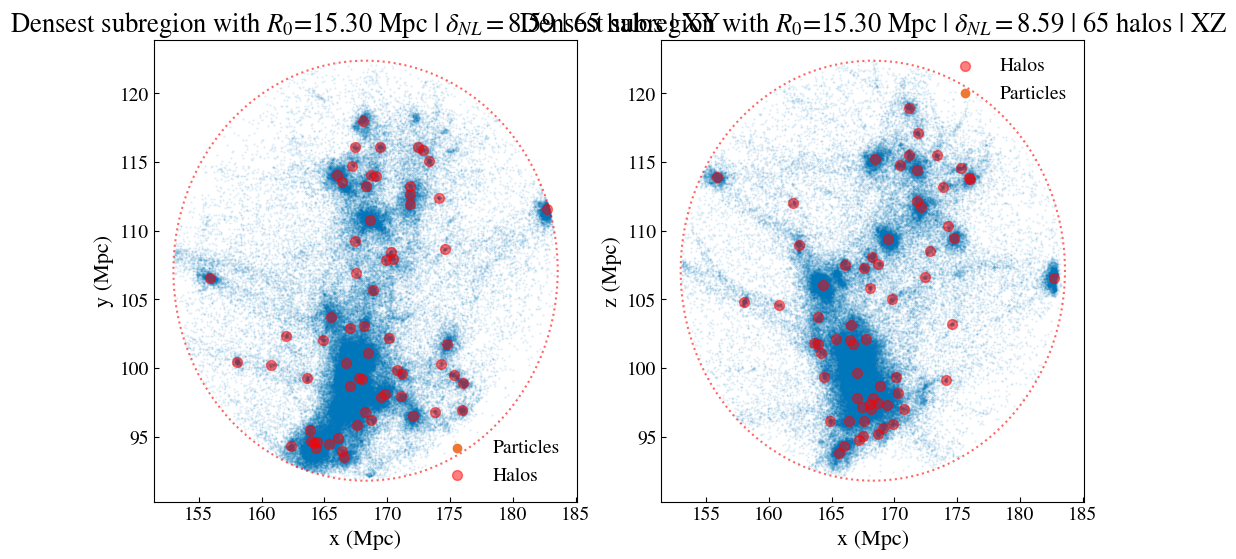

In [43]:
sr_highest_mass = subreg_sorted[-1]

idx_part_in_highest_mass_sr = sr_highest_mass.get_idx_particles_inside(part_pos_mpc)

idx_halo_in_highest_mass_sr = sr_highest_mass.get_idx_particles_inside(halo_pos_mpc)

part_alpha = 0.15
part_size = 0.2

halo_alpha = 0.5
halo_size = 50
halo_color = "red"

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.scatter(x_mpc[idx_part_in_highest_mass_sr], y_mpc[idx_part_in_highest_mass_sr], z_mpc[idx_part_in_highest_mass_sr], alpha=part_alpha, s=part_size)
ax.scatter([],[],[], label = "Particles")
ax.scatter(xh_mpc[idx_halo_in_highest_mass_sr], yh_mpc[idx_halo_in_highest_mass_sr], zh_mpc[idx_halo_in_highest_mass_sr], alpha=0.5, s=halo_size, color=halo_color, label = "Halos")
ax.set_xlabel("x (Mpc)")
ax.set_ylabel("y (Mpc)")
ax.set_zlabel("z (Mpc)")
ax.set_title(f"Densest subregion with $R_0$={radius_sr:.2f} Mpc | $\delta_{{NL}}={sr_highest_mass.delta_NL:.2f}$ | {len(idx_halo_in_highest_mass_sr)} halos")
ax.legend()

fig, (ax_xy, ax_xz) = plt.subplots(1, 2, figsize=(12, 6))

ax_xy.scatter(x_mpc[idx_part_in_highest_mass_sr], y_mpc[idx_part_in_highest_mass_sr], alpha=part_alpha, s=part_size)
ax_xy.scatter([],[], label = "Particles")
ax_xy.scatter(xh_mpc[idx_halo_in_highest_mass_sr], yh_mpc[idx_halo_in_highest_mass_sr], alpha=halo_alpha, s=halo_size, color=halo_color, label = "Halos")

if shape == "sphere":
    circle = plt.Circle((sr_highest_mass.center[0], sr_highest_mass.center[1]), radius_sr, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
    ax_xy.add_patch(circle)
elif shape == "cube":
    ax_xy.axvline(sr_highest_mass.center[0] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axvline(sr_highest_mass.center[0] + sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axhline(sr_highest_mass.center[1] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axhline(sr_highest_mass.center[1] + sr_highest_mass.radius, color='r', linestyle='dotted')
    
ax_xy.set_xlabel("x (Mpc)")
ax_xy.set_ylabel("y (Mpc)")
ax_xy.set_title(f"Densest subregion with $R_0$={radius_sr:.2f} Mpc | $\delta_{{NL}}={sr_highest_mass.delta_NL:.2f}$ | {len(idx_halo_in_highest_mass_sr)} halos | XY")
ax_xy.legend()


ax_xz.scatter(x_mpc[idx_part_in_highest_mass_sr], z_mpc[idx_part_in_highest_mass_sr], alpha=part_alpha, s=part_size)
ax_xz.scatter(xh_mpc[idx_halo_in_highest_mass_sr], zh_mpc[idx_halo_in_highest_mass_sr], alpha=halo_alpha, s=halo_size, color=halo_color, label = "Halos")
ax_xz.scatter([],[], label = "Particles")
if shape == "sphere":
    circle = plt.Circle((sr_highest_mass.center[0], sr_highest_mass.center[2]), radius_sr, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
    ax_xz.add_patch(circle)
elif shape == "cube":
    ax_xz.axvline(sr_highest_mass.center[0] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xz.axvline(sr_highest_mass.center[0] + sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xz.axhline(sr_highest_mass.center[1] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xz.axhline(sr_highest_mass.center[1] + sr_highest_mass.radius, color='r', linestyle='dotted')
ax_xz.set_xlabel("x (Mpc)")
ax_xz.set_ylabel("z (Mpc)")
ax_xz.set_title(f"Densest subregion with $R_0$={radius_sr:.2f} Mpc | $\delta_{{NL}}={sr_highest_mass.delta_NL:.2f}$ | {len(idx_halo_in_highest_mass_sr)} halos | XZ")
ax_xz.legend()

plt.show()

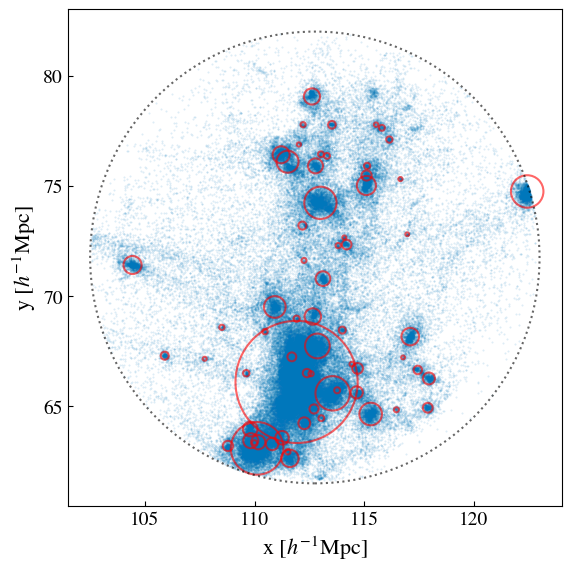

In [44]:
fig, ax_xy = plt.subplots(figsize=(6, 6))

size_mh = mh[idx_halo_in_highest_mass_sr] / mh[0] * 10000

ax_xy.scatter(x_mpc[idx_part_in_highest_mass_sr]*h, y_mpc[idx_part_in_highest_mass_sr]*h, alpha=part_alpha, s=part_size,rasterized=True)
ax_xy.scatter([], [], color="#0077BB",  label="Particles")
ax_xy.scatter(xh_mpc[idx_halo_in_highest_mass_sr]*h, yh_mpc[idx_halo_in_highest_mass_sr]*h, alpha=0.6, lw=1.5, s=size_mh, color=halo_color, label="Halos", facecolors='none',
            rasterized=True)

if shape == "sphere":
    circle = plt.Circle((sr_highest_mass.center[0]*h, sr_highest_mass.center[1]*h), radius_sr*h, color='k', alpha=0.6, linestyle='dotted', fill=False, linewidth=1.5)
    ax_xy.add_patch(circle)
elif shape == "cube":
    ax_xy.axvline(sr_highest_mass.center[0] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axvline(sr_highest_mass.center[0] + sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axhline(sr_highest_mass.center[1] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axhline(sr_highest_mass.center[1] + sr_highest_mass.radius, color='r', linestyle='dotted')

ax_xy.set_xlabel("x [$h^{{-1}}$Mpc]")
ax_xy.set_ylabel("y [$h^{{-1}}$Mpc]")
# ax_xy.set_title(f"$R_0$={radius_sr*h:.2f} $h^{{-1}}$Mpc | $\delta_{{NL}}={sr_highest_mass.delta_NL:.2f}$ | {len(idx_halo_in_highest_mass_sr)} halos")
# ax_xy.legend()
plt.tight_layout()
plt.savefig(f"./saved_results/misc/halos_densest_{nb_iter}.svg", dpi=300, bbox_inches='tight')
plt.show()

In [45]:
deltadm,rhodm=part2cic(positions, Ncut, contrast=True)

avg rho 32768.00000000001
16777216.000000004


/home/mesquita/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6902: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


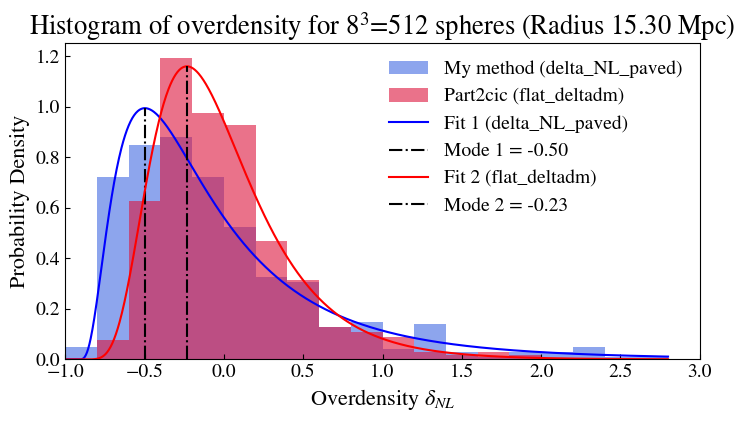

In [46]:
from scipy.stats import lognorm

plt.figure()
bin_edges = np.arange(-1, 3, 0.2)
count, bins, _ = plt.hist(delta_NL_paved, bins=bin_edges, density=True, alpha=0.6, color='royalblue', label="My method (delta_NL_paved)")
flat_deltadm = deltadm.flatten()
count_ddm, bins_ddm, _ = plt.hist(flat_deltadm, bins=bin_edges, density=True, alpha=0.6, color='crimson', label="Part2cic (flat_deltadm)")

x = np.linspace(bins[0], bins[-1], 1000)
shape_my, loc_my, scale_my = lognorm.fit(delta_NL_paved)
lognormfit_my = lognorm.pdf(x, shape_my, loc_my, scale_my)
lognorm_mode_my = x[np.argmax(lognormfit_my)]

plt.plot(x, lognormfit_my, 'b-', label="Fit 1 (delta_NL_paved)")
plt.vlines(lognorm_mode_my, 0, np.max(lognormfit_my), linestyle="dashdot", color="black", label=f"Mode 1 = {lognorm_mode_my:.2f}")

shape_p2cic, loc_p2cic, scale_p2cic = lognorm.fit(flat_deltadm)
lognormfit_p2cic = lognorm.pdf(x, shape_p2cic, loc_p2cic, scale_p2cic)
lognorm_mode_p2cic = x[np.argmax(lognormfit_p2cic)]

plt.plot(x, lognormfit_p2cic, 'r-', label="Fit 2 (flat_deltadm)")
plt.vlines(lognorm_mode_p2cic, 0, np.max(lognormfit_p2cic), linestyle="dashdot", color="black", label=f"Mode 2 = {lognorm_mode_p2cic:.2f}")

plt.title(f"Histogram of overdensity for ${Ncut}^3$={Ncut**3} {shape}s (Radius {subreg_list[0].radius:.2f} Mpc)")
plt.xlabel("Overdensity $\\delta_{NL}$")
plt.ylabel("Probability Density")
plt.xlim(-1, 3)
plt.tight_layout()
plt.legend()
plt.show()

# Plot subregions

## functions

In [47]:
def plot_sub_cmf(subreg_sorted, arg, method="range", save_name = None):
    '''
    args is either :
        -a list of the bins of delta_NL if the method is range
        -a number of subregions to cut if the method is number
    method : "range" or "number"
    '''
    cmap = cm.viridis
    norm = plt.Normalize(vmin=-1, vmax=2.5)
    color = cmap(norm(delta_NL_paved))
    fig, ax = plt.subplots(2, 1, figsize=(13, 10))
    
    if method == "range":
        dNL_range = arg
        lower_bound = dNL_range[0]
        upper_bound = dNL_range[-1]
        indiv_range = dNL_range[1] - dNL_range[0]
        
        nb_iter = len(dNL_range) - 1
        ax[0].set_title(f"Avg of CMF every for different ranges of $\delta_{{NL}}\in [{arg[0]},{arg[-1]}]$")
        ax[1].set_title(f"Range in overdensities in $\delta_{{NL}}\in [{arg[0]},{arg[-1]}]$")
    elif method == "number":
        count_cut = arg
        nb_iter = len(subreg_sorted) // count_cut + 1
        if count_cut == (Ncut**3):
            ax[0].plot(bcen_hmf,mydndm_hmf,'-o',markersize=5, color = "k", label=f"HMF",alpha=0.3)
        ax[0].set_title(f"Avg of CMF every {count_cut} out of {Ncut**3} {shape}s")
        ax[1].set_title(f"Range in overdensities, every {count_cut} out of {Ncut**3} {shape}s")
    # elif method == "halo_count":
    #     halo_cut = arg
    #     nb_iter = len(subreg_sorted) // count_cut + 1

    print("nb_iter", nb_iter)

    # first plot
    for i in range(nb_iter):
        if method == "range":
            # if i != nb_iter-1 :
            #     w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
            #     sr_of_interest = subreg_sorted[w]
            #     color_idx = int((w[0]+w[-1])/2)
            # else :
            #     w = np.where(delta_NL_paved >= dNL_range[i])[0]
            #     sr_of_interest = subreg_sorted[w]
            #     color_idx = int((w[0]+len(subreg_sorted))/2)
            w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
            sr_of_interest = subreg_sorted[w]
            if len(w)>0:
                color_idx = int((w[0]+w[-1])/2)
            else : 
                color_idx = 0
            
        elif method == "number":
            if i != nb_iter-1 :
                sr_of_interest = subreg_sorted[count_cut*i:count_cut*(i+1)]
                color_idx = int((count_cut*i+count_cut*(i+1))/2)
            else : 
                sr_of_interest = subreg_sorted[count_cut*i:]
                color_idx = int((count_cut*i+len(subreg_sorted))/2)
        
        # elif method == "halo_count":
        #     if i != nb_iter-1 :
        #         sr_of_interest = subreg_sorted[count_cut*i:count_cut*(i+1)]
        #         color_idx = int((count_cut*i+count_cut*(i+1))/2)
            
        
        halos_found = np.sum([sr.num_halos for sr in sr_of_interest])
        nb_reg = len(sr_of_interest)
        if nb_reg != 0:
            
            delta_NL_values = np.array([sr.delta_NL for sr in sr_of_interest if sr.cmf_th_cST is not None])
            min_index = np.argmin(delta_NL_values)
            max_index = np.argmax(delta_NL_values)
            mean_dNL = np.mean([sr.delta_NL for sr in sr_of_interest])
            mean_dL = np.mean([sr.delta_L for sr in sr_of_interest])
            
            ###### avg of cmf ######
            ###### theory
            ### cmf(avg(delta_L))
            # avg_cmf_from_dL = [mycmf.cmfcalc(M_list[ii], kh, pk, (sr_of_interest[0].radius*h)*nb_reg**(1/3), mean_dL, model="cST") for ii in range(len(M_list))]
            # ax[0].loglog(M_list, avg_cmf_from_dL, '-', color=color[color_idx], alpha=0.8)
            
            ### avg(n_cST(delta_L))
            all_ncST_th = [sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None]
            avg_ncST_filtered = np.mean(all_ncST_th, axis=0)
            ax[0].loglog(M_list, avg_ncST_filtered, '--', color=color[color_idx], alpha=0.8) #, label = f"$\delta_L={mean_dL_directly:.2f}$"
            
            ### avg(n_EPS(delta_L))
            # all_nEPS_th = [sr.cmf_th_EPS for sr in sr_of_interest if sr.cmf_th_EPS is not None]
            # avg_nEPS_filtered = np.mean(all_nEPS_th, axis=0)
            # ax[0].loglog(M_list, avg_nEPS_filtered, '-', color=color[color_idx], alpha=0.8) #, label = f"$\delta_L={mean_dL_directly:.2f}$"
            
            
            ###### empirical
            ## avg of emp cmf
            avg_cmf_emp = np.mean([sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None], axis=0)
            avg_bcen_emp = np.mean([sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None], axis=0)

            ## errors
            err_sr = np.array([sr.err_emp for sr in sr_of_interest if sr.err_emp is not None])
            
            upper_errors = err_sr[:, 0, :]
            lower_errors = err_sr[:, 1, :]
            
            mean_upper_error = np.sqrt(np.sum(upper_errors ** 2, axis=0)) / len(err_sr)
            mean_lower_error = np.sqrt(np.sum(lower_errors ** 2, axis=0)) / len(err_sr)
            
            if method == "range":
                ax[0].errorbar(avg_bcen_emp, avg_cmf_emp,
                                yerr=[mean_lower_error, mean_upper_error], 
                                fmt='o-', markersize=5, alpha=0.7, color=color[color_idx],
                                label=f"Nb_subreg={len(sr_of_interest)} |  {halos_found} halos | $\delta_{{NL}} \in [{lower_bound+i*indiv_range},{lower_bound+(i+1)*indiv_range}]$ | $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$")
            elif method == "number":
                ax[0].errorbar(avg_bcen_emp, avg_cmf_emp,
                                yerr=[mean_lower_error, mean_upper_error], 
                                fmt='o-', markersize=5, alpha=0.7, color=color[color_idx],
                                label=f"Nb_subreg={len(sr_of_interest)} |  {halos_found} halos | $\delta_{{NL}} \in [{delta_NL_values[min_index]:.2f}, {delta_NL_values[max_index]:.2f}]$ | $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$")
            
            ### avg with halos
            halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])
            halos_idx = np.concatenate(halos_idx_list)
            mh_in_all_sr = mh[halos_idx]
            current_bins=np.logspace(11, 16,num=nbins)

            current_bcen=0.5*(current_bins[1:]+current_bins[:-1])
            current_db=current_bins[1:]-current_bins[:-1]
            current_cmf, current_bin_edges = np.histogram(mh_in_all_sr*h,bins=current_bins) 
            
            if shape == "sphere":
                V_all_sr = nb_reg * 4/3*np.pi*(sr_of_interest[0].radius*h)**3
            elif shape == "cube":
                V_all_sr = nb_reg * (sr_of_interest[0].radius*h)**3
            
            current_dndm=current_cmf/current_db/V_all_sr
            
            #error bars
            current_dndm_upper_err=current_dndm+3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
            current_dndm_lower_err=current_dndm-3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
            dndm_err = [current_dndm_upper_err, current_dndm_lower_err]
            
            # ax[0].errorbar(current_bcen, current_dndm,
            #                 yerr=[current_dndm - dndm_err[1], dndm_err[0] - current_dndm], 
            #                 fmt='*-', markersize=9, alpha=0.7, color=color[color_idx]) #f"Sum halos to $CMF_{{emp}}$ | $\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos"

    # ax[0].loglog([],[], '-', color="k", label=f"$n_{{cST}}$(Avg($\delta_{{NL}}$))")
    ax[0].loglog([],[], '--', color="k", label=f"Avg($CMF_{{th}}(\delta_{{NL}})$)")
    ax[0].scatter([], [], marker='o', color="k", label=f"Avg($CMF_{{emp}}$)")
    # ax[0].scatter([], [], marker='*', color="k", label=f"Sum halos to $CMF_{{emp}}$")

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax[0])
    cbar.set_label(f'Overdensity $\delta_{{NL}}$')

    ax[0].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
    ax[0].set_ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
    ax[0].set_xlim([2e12,5e14])
    ax[0].set_ylim([1e-20,1e-15])
    ax[0].legend(bbox_to_anchor=(1.2, 1), loc='upper left')
    # ax[0].legend()

    # second plot
    bin_edges = np.arange(-1, 3, 0.2)
    count, bins, _ = ax[1].hist(delta_NL_paved, bins=bin_edges, density=True, alpha=0.6, color='dimgrey')

    ax[1].axvline(-1, color=color[0], linestyle='dashed')
    
    for i in range(nb_iter):
        if method == "range":
            w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
            if len(w)>0:
                color_idx = int((w[0]+w[-1])/2)
            else :
                color_idx = 0
            ax[1].axvline(lower_bound+(i+1)*indiv_range, color=color[color_idx], linestyle='dashed')
        elif method == "number":
            dNL_range_left = delta_NL_paved[count_cut*(i)-1]
            ax[1].axvline(dNL_range_left, color=color[count_cut*(i)-1], linestyle='dashed')
    ax[1].plot([],[], color='black', linestyle='dashed', alpha=0.7, label="Ranges of $\delta_{NL}$")

    ax[1].set_xlim(-1.1, 3)
    
    ax[1].set_xlabel(r"$\delta_{NL}$")
    ax[1].set_ylabel("Density probability")
    ax[1].legend()
    if save_name is not None:
        plt.savefig(save_name)
    plt.tight_layout()
    plt.show()

In [48]:
from matplotlib.ticker import LogLocator

def plot_every_sub_cmf(subreg_sorted, arg, method="range", save_name = None):
    '''
    args is either :
        -a list of the bins of delta_NL if the method is range
        -a number of subregions to cut if the method is number
    method : "range" or "number"
    '''
    
    if method == "range":
        dNL_range = arg
        nb_iter = len(dNL_range) - 1
        lower_bound = dNL_range[0]
        upper_bound = dNL_range[-1]
        indiv_range = dNL_range[1] - dNL_range[0]
    elif method == "number":
        count_cut = arg
        nb_iter = (len(subreg_sorted) // count_cut + 1 )-1
        
    cmap = cm.viridis
    norm = plt.Normalize(vmin=-1, vmax=2.5)
    color = cmap(norm(delta_NL_paved))
    # fig, ax = plt.subplots(nb_iter, 1, figsize=(8, 5 * nb_iter)) 
    
    fig, ax = plt.subplots(nb_iter, 1, figsize=(6, 5 * nb_iter))   
        

    print("nb_iter", nb_iter)
    
    if nb_iter == 1:
        ax = [ax]

    for i in range(nb_iter):
        if method == "range":
            # if i != nb_iter-1 :
            #     w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
            #     sr_of_interest = subreg_sorted[w]
            #     color_idx = int((w[0]+w[-1])/2)
            # else :
            #     w = np.where(delta_NL_paved >= dNL_range[i])[0]
            #     sr_of_interest = subreg_sorted[w]
            #     color_idx = int((w[0]+len(subreg_sorted))/2)
            
            
            w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
            
            # w = np.where((delta_NL_paved >= -0.5) & (delta_NL_paved < 0.0))[0]
            sr_of_interest = subreg_sorted[w]
            if len(w)>0:
                color_idx = int((w[0]+w[-1])/2)
            else :
                color_idx = 0
        elif method == "number":
            if i != nb_iter-1 :
                sr_of_interest = subreg_sorted[count_cut*i:count_cut*(i+1)]
                color_idx = int((count_cut*i+count_cut*(i+1))/2)

            else : 
                sr_of_interest = subreg_sorted[count_cut*i:]
                color_idx = int((count_cut*i+len(subreg_sorted))/2)
                
        halos_found = np.sum([sr.num_halos for sr in sr_of_interest])
        nb_reg = len(sr_of_interest)
        
        if len(sr_of_interest) != 0:
            delta_NL_values = np.array([sr.delta_NL for sr in sr_of_interest if sr.cmf_th_cST is not None])
            cmf_values = np.array([sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None])
            
            if len(cmf_values) > 0:
                dNL_sr_of_interest = np.array([sr.delta_NL for sr in sr_of_interest])
                mean_dNL = np.mean(dNL_sr_of_interest)
                mean_dL = np.mean([sr.delta_L for sr in sr_of_interest])
                
                if method == "range":
                    title_text = f"z=0 | $\delta_{{NL}} \in [{lower_bound+i*indiv_range},{lower_bound+(i+1)*indiv_range}]$\n{halos_found} halos in {len(sr_of_interest)} regions"
                elif method == "number":
                    title_text = f"$\delta_{{NL}} \in [{delta_NL_values[min_index]:.2f}, {delta_NL_values[max_index]:.2f}]$\n{halos_found} halos in {len(sr_of_interest)} regions"
                ax[i].plot([], [], ' ', label=title_text)
            

                # avg_cmf_from_dL = [mycmf.cmfcalc(M_list[ii], kh, pk, (sr_of_interest[0].radius*h), mean_dL, mean_dNL, model="QcST") for ii in range(len(M_list))]
                # ax[i].loglog(M_list, avg_cmf_from_dL, '-', color="red", alpha=0.8)
                
                # avg_cmf_from_dL = [mycmf.cmfcalc(M_list[ii], kh, pk, sr_of_interest[0].radius*h, mycmf.compute_delta_linear(mean_dNL), model="cST") for ii in range(len(M_list))]
                # # ax[i].loglog(M_list, avg_cmf_from_dL, '-', color=color[color_idx], alpha=0.8)
                # ax[i].loglog(M_list, avg_cmf_from_dL, '-', color="red", alpha=0.4)

                # all_nEPS_th = [sr.cmf_th_EPS for sr in sr_of_interest if sr.cmf_th_EPS is not None]
                # avg_nEPS_filtered = np.mean(all_nEPS_th, axis=0)
                # ax[i].loglog(M_list, avg_nEPS_filtered, '-', color="blue", alpha=0.8) #, label = f"$\delta_L={mean_dL_directly:.2f}$"
                
                all_cmf_th = [sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None]
                
                all_cmf_emp = [sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None]
                sr_filtered = [sr for sr in sr_of_interest if sr.cmf_emp is not None]
                
                all_bcen_emp = [sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None]
                
                for idx,cmf_th in enumerate(all_cmf_th):
                    if method=="range":
                        ax[i].loglog(M_list, cmf_th, '-', color=color[w[0]+idx], alpha=0.065)
                    elif method=="number":
                        ax[i].loglog(M_list, cmf_th, '-', color=color[count_cut*i+idx], alpha=0.065)
                
                # for idx, cmf_emp in enumerate(all_cmf_emp):
                #     if method == "range":
                #         ax[i].loglog(all_bcen_emp[idx], cmf_emp, '-o', markersize=5, alpha=0.5, color=color[w[0]+idx])
                #     else :
                #         ax[i].loglog(all_bcen_emp[idx], cmf_emp, '-o', markersize=5, alpha=0.5, color=color[count_cut*i+idx])
                
                avg_cmf_filtered = np.mean(all_cmf_th, axis=0)
                ax[i].loglog(M_list, avg_cmf_filtered, '--', color="k", alpha=0.8) #, label = f"$\delta_L={mean_dL_directly:.2f}$"
                
                # from simulation
                avg_cmf_emp = np.average([sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None], axis=0)
                avg_bcen_emp = np.average([sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None], axis=0)

                med_cmf_emp = np.median([sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None], axis=0)
                med_bcen_emp = np.median([sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None], axis=0)
                ##errors
                err_sr = np.array([sr.err_emp for sr in sr_of_interest if sr.err_emp is not None])
                
                upper_errors = err_sr[:, 0, :]
                lower_errors = err_sr[:, 1, :]
                
                mean_upper_error = np.sqrt(np.sum(upper_errors ** 2, axis=0)) / len(err_sr)
                mean_lower_error = np.sqrt(np.sum(lower_errors ** 2, axis=0)) / len(err_sr)
                
                if i == 0 :
                    ax[i].errorbar(avg_bcen_emp, avg_cmf_emp,
                        yerr=[mean_lower_error, mean_upper_error], 
                        fmt='o-', markersize=5, alpha=0.7, color="k",#color=color[color_idx],
                        # label=f"Avg($CMF_{{emp}}$)"
                        )
                        
                    ax[i].loglog([],[], '--', color="k",)# label=f"Avg($n_{{cST}}(\delta_{{NL}})$)")
                else : 
                    ax[i].errorbar(avg_bcen_emp, avg_cmf_emp,
                        yerr=[mean_lower_error, mean_upper_error], 
                        fmt='o-', markersize=5, alpha=0.7, color="k")
                # ax[i].scatter(avg_bcen_emp, avg_cmf_emp, s=20, color="k", alpha=0.9, label=f"Avg($CMF_{{emp}}$)")
                # ax[i].scatter(med_bcen_emp, med_cmf_emp, s=20, color="red", alpha=0.9, label=f"Median($CMF_{{emp}}$)")
                # ax[i].plot(med_bcen_emp, med_cmf_emp, '-o', markersize=5, color="red", alpha=0.5, label=f"Median($CMF_{{emp}}$)")
                
                ### avg with halos
                halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])
                halos_idx = np.concatenate(halos_idx_list)
                mh_in_all_sr = mh[halos_idx]
                current_bins=np.logspace(11, 16,num=nbins)

                current_bcen=0.5*(current_bins[1:]+current_bins[:-1])
                current_db=current_bins[1:]-current_bins[:-1]
                current_cmf,current_bin_edges = np.histogram(mh_in_all_sr*h,bins=current_bins) 
                
                if shape == "sphere":
                    V_all_sr = nb_reg * 4/3*np.pi*(sr_of_interest[0].radius*h)**3
                elif shape == "cube":
                    V_all_sr = nb_reg * (sr_of_interest[0].radius*h)**3
                    
                current_dndm=current_cmf/current_db/V_all_sr
                
                #error bars
                current_dndm_upper_err=current_dndm+3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
                current_dndm_lower_err=current_dndm-3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
                dndm_err = [current_dndm_upper_err, current_dndm_lower_err]
                
                # ax[i].errorbar(current_bcen, current_dndm,
                #                 yerr=[current_dndm - dndm_err[1], dndm_err[0] - current_dndm], 
                #                 fmt='*-', markersize=7, alpha=0.7, color=color[color_idx],
                #                 label=f"Sum halos to $CMF_{{emp}}$ | $\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos")
                
                # ## min and max
                max_index = np.argmax(delta_NL_values)
                min_index = np.argmin(delta_NL_values)
                
                max_cmf = sr_of_interest[max_index].cmf_th_cST
                min_cmf = sr_of_interest[min_index].cmf_th_cST
                
                ax[i].loglog(M_list, min_cmf, '-', color=color[int(color_idx/2)], alpha=0.4, label=f"Min $\delta_{{NL}}$={delta_NL_values[min_index]:.2f}")
                ax[i].loglog(M_list, max_cmf, '-', color=color[int((color_idx+len(color))/2)], alpha=0.4, label=f"Max $\delta_{{NL}}$={delta_NL_values[max_index]:.2f}")
                # ax[i].fill_between(M_list,min_cmf,max_cmf, color=color[color_idx], alpha=0.15)
                
                # ax[i].loglog([],[], '-', color=color[color_idx], label=f"$n_{{cST}}$(Avg($\delta_{{NL}}$))")
                
                # ax[i].loglog([],[], '-', color="red", label=f"$n_{{cST}}(Avg((\delta_{{L}})_N))$")
                # ax[i].loglog([],[], '-', color="blue", label=f"$n_{{EPS}}(Avg((\delta_{{L}})_N))$")
                # if method=="range":
                #     ax[i].set_title(f"CMF $\delta_{{NL}} \in [{lower_bound+i*indiv_range},{lower_bound+(i+1)*indiv_range}]$ finds {len(sr_of_interest)} subreg with {halos_found} halos and $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$  ")
                # elif method == "number":
                #     ax[i].set_title(f"CMF for {len(sr_of_interest)} subreg with {halos_found} halos and $\delta_{{NL}} \in [{delta_NL_values[min_index]:.2f}, {delta_NL_values[max_index]:.2f}]$ with $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$.")
                


                
                # ax[i].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
                if i == nb_iter - 1:
                    ax[i].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
                else:
                    ax[i].set_xlabel("")
                    ax[i].set_xticklabels([])
                

                ax[i].set_ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
                # ax[i].set_xlim([2e12,5e14])
                # ax[i].set_ylim([1e-20,1e-15])
                ax[i].set_xlim([2e12,5e14])
                ax[i].set_yscale('log')
                ax[i].set_ylim([1e-20,1e-15])
                ticks = [1e-19, 1e-18, 1e-17, 1e-16, 1e-15]
                if i == nb_iter - 1:
                    ticks = [1e-20] + ticks
                    ax[i].set_yticks(ticks)
                else : 
                    ax[i].set_yticks(ticks)
                ax[i].legend(loc="upper right", alignment='left')
                ax[i].grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.3)
                
                


    plt.tight_layout()
    if save_name is not None:
        plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.subplots_adjust(hspace=0)
    plt.show()


## plotting

In [49]:
indiv_range = 0.5
lower_bound = -1
upper_bound = 1.6
dNL_range = np.arange(lower_bound, upper_bound, indiv_range)
count_cut = 128

method_sub_cmf = "range"

In [50]:
if method_sub_cmf == "range":
    arg_sub_cmf = dNL_range
elif method_sub_cmf == "number":
    arg_sub_cmf =  count_cut

print("method is", method_sub_cmf)
print("arg_sub_cmf", arg_sub_cmf)

method is range
arg_sub_cmf [-1.  -0.5  0.   0.5  1.   1.5]


nb_iter 5


/tmp/ipykernel_1660058/3852715966.py:120: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])


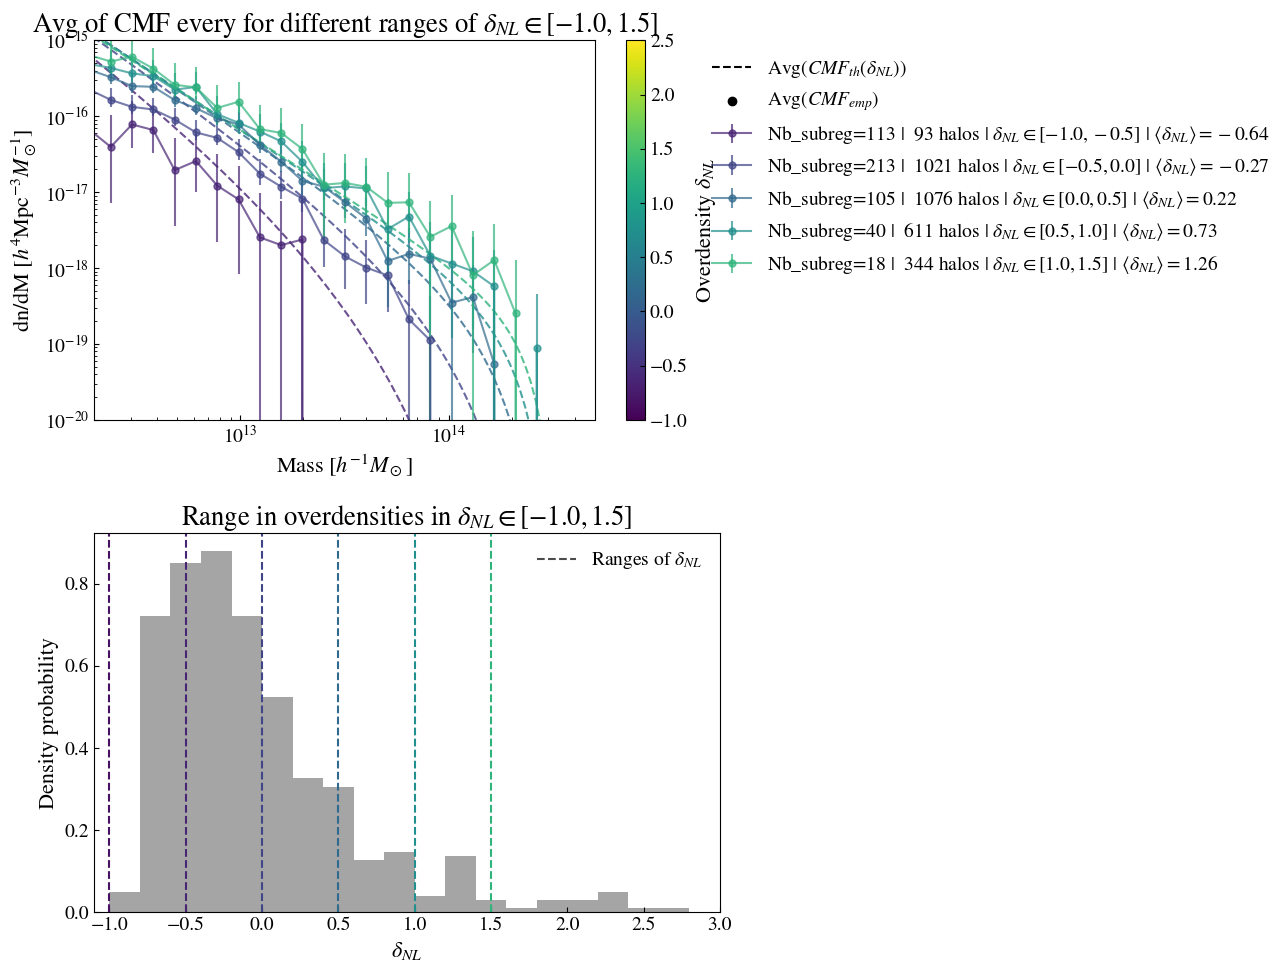

In [51]:
plot_sub_cmf(subreg_sorted, arg_sub_cmf, method=method_sub_cmf, save_name = None)

nb_iter 1


/tmp/ipykernel_1660058/4253542632.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])


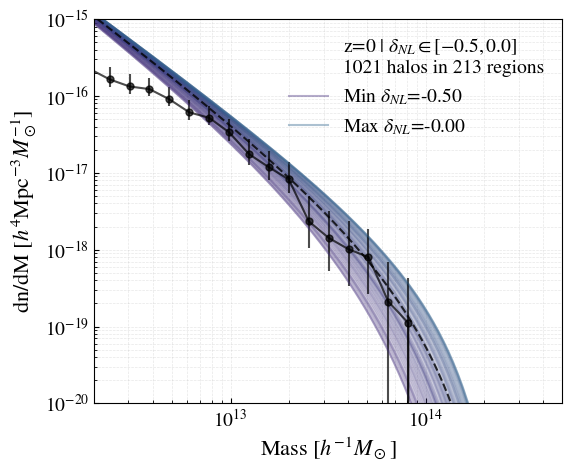

In [52]:
# plot_every_sub_cmf(subreg_sorted, arg_sub_cmf, method=method_sub_cmf)
plot_every_sub_cmf(subreg_sorted, np.array([-0.5,0.0]), method=method_sub_cmf, save_name="./mid_overdensity_cmf.svg")


In [53]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from matplotlib import gridspec

def compute_age_Gyr(z, H0=H0org, om=om):
    """
    H0 in km/s/Mpc
    """
    H0_astropy = H0 * u.km / u.s / u.Mpc
    cosmo = FlatLambdaCDM(H0=H0_astropy, Om0=om)
    age = cosmo.age(z).to(u.Gyr).value
    return age

def plot_every_sub_cmf2(subreg_sorted,  arg, delta_NL_paved, Ncut, mh, nbins, M_list, shape = "sphere", method="range", showfig=True, z=None, savename=None):
    '''
    args is either :
        -a list of the bins of delta_NL if the method is range
        -a number of subregions to cut if the method is number
    method : "range" or "number"
    '''

    if method == "range":
        dNL_range = arg
        nb_iter = len(dNL_range) - 1
        lower_bound = dNL_range[0]
        upper_bound = dNL_range[-1]
        indiv_range = dNL_range[1] - dNL_range[0]
    elif method == "number":
        count_cut = arg
        nb_iter = (len(subreg_sorted) // count_cut + 1 )-1
        
    cmap = cm.viridis
    norm = plt.Normalize(vmin=-1, vmax=2.5)
    color = cmap(norm(delta_NL_paved))
    
    nb_plots = nb_iter + 1  # +1 for the histogram plot
    ncols = 3
    nrows = (nb_plots + ncols - 1) // ncols  # pure numpy-compatible ceiling
    fig, ax = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), )#sharex=True, sharey=True
    ax = np.array(ax).reshape(-1)
    
    for j in range(nb_iter+1, len(ax)):
        ax[j].set_visible(False)
    
    if nb_iter == 1:
        ax = [ax]

    for i in range(nb_iter):
        if method == "range":
            # if i != nb_iter-1 :
            #     w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
            #     sr_of_interest = subreg_sorted[w]
            #     color_idx = int((w[0]+w[-1])/2)
            # else :
            #     w = np.where(delta_NL_paved >= dNL_range[i])[0]
            #     sr_of_interest = subreg_sorted[w]
            #     color_idx = int((w[0]+len(subreg_sorted))/2)
            w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
            sr_of_interest = subreg_sorted[w]
            if len(w)>0:
                color_idx = int((w[0]+w[-1])/2)
            else :
                color_idx = 0
        elif method == "number":
            if i != nb_iter-1 :
                sr_of_interest = subreg_sorted[count_cut*i:count_cut*(i+1)]
                color_idx = int((count_cut*i+count_cut*(i+1))/2)

            else : 
                sr_of_interest = subreg_sorted[count_cut*i:]
                color_idx = int((count_cut*i+len(subreg_sorted))/2)
                
        halos_found = np.sum([sr.num_halos for sr in sr_of_interest])
        nb_reg = len(sr_of_interest)
        
        if len(sr_of_interest) != 0:
            delta_NL_values = np.array([sr.delta_NL for sr in sr_of_interest if sr.cmf_th_cST is not None])
            cmf_values = np.array([sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None])
            halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])
            if len(halos_idx_list) > 0:
                radius_sr = sr_of_interest[0].radius
                # ax[i].axvline(R_to_M(radius_sr*h), color="k", linestyle='dashed', alpha=0.3)
                
                dNL_sr_of_interest = np.array([sr.delta_NL for sr in sr_of_interest])
                mean_dNL = np.mean(dNL_sr_of_interest)
                mean_dL = np.mean([sr.delta_L for sr in sr_of_interest])

                if method == "range":
                    title_text = f"$\delta_{{NL}} \in [{lower_bound+i*indiv_range},{lower_bound+(i+1)*indiv_range}]$\n{len(sr_of_interest)} regions with {halos_found} halos"
                elif method == "number":
                    title_text = f"$\delta_{{NL}} \in [{delta_NL_values[min_index]:.2f}, {delta_NL_values[max_index]:.2f}]$\n{len(sr_of_interest)} regions with {halos_found} halos"
                ax[i].plot([], [], ' ', label=title_text)
                
                # avg_cmf_from_dL = [mycmf.cmfcalc(M_list[ii], kh, pk, (sr_of_interest[0].radius*h)*nb_reg**(1/3), mean_dL, model="cST") for ii in range(len(M_list))]
                # ax[i].loglog(M_list, avg_cmf_from_dL, '-', color=color[color_idx], alpha=0.8)
                all_cmf_th = [sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None]
                all_cmf_emp = [sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None]
                all_bcen_emp = [sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None]
                
                for idx,cmf_th in enumerate(all_cmf_th):
                    if method=="range":
                        ax[i].loglog(M_list, cmf_th, '-', color=color[w[0]+idx], alpha=0.065)
                    elif method=="number":
                        ax[i].loglog(M_list, cmf_th, '-', color=color[count_cut*i+idx], alpha=0.065)
                
                # for idx, cmf_emp in enumerate(all_cmf_emp):
                #     if method == "range":
                #         ax[i].loglog(all_bcen_emp[idx], cmf_emp, '-o', markersize=5, alpha=0.5, color=color[w[0]+idx])
                #     else :
                #         ax[i].loglog(all_bcen_emp[idx], cmf_emp, '-o', markersize=5, alpha=0.5, color=color[count_cut*i+idx])

                avg_cmf_filtered = np.mean(all_cmf_th, axis=0)
                ax[i].loglog(M_list, avg_cmf_filtered, '--', color="k", alpha=0.8) #, label = f"$\delta_L={mean_dL_directly:.2f}$"
                
                # from simulation
                avg_cmf_emp = np.average([sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None], axis=0)
                avg_bcen_emp = np.average([sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None], axis=0)

                med_cmf_emp = np.median([sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None], axis=0)
                med_bcen_emp = np.median([sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None], axis=0)
                ##errors
                err_sr = np.array([sr.err_emp for sr in sr_of_interest if sr.err_emp is not None])
                
                upper_errors = err_sr[:, 0, :]
                lower_errors = err_sr[:, 1, :]
            
                mean_upper_error = np.sqrt(np.sum(upper_errors ** 2, axis=0)) / len(err_sr)
                mean_lower_error = np.sqrt(np.sum(lower_errors ** 2, axis=0)) / len(err_sr)
                
                if i == 0:
                    ax[i].errorbar(avg_bcen_emp, avg_cmf_emp,
                            yerr=[mean_lower_error, mean_upper_error], 
                            fmt='o-', markersize=5, alpha=0.7, color="k",#color=color[color_idx],
                            # label=f"Avg($CMF_{{emp}}$)"
                            )
                    ax[i].loglog([],[], '--', color="k", 
                                #  label=f"Avg($CMF_{{th}}(\delta_{{NL}})$)"
                                 )
                else :
                    ax[i].errorbar(avg_bcen_emp, avg_cmf_emp,
                            yerr=[mean_lower_error, mean_upper_error], 
                            fmt='o-', markersize=5, alpha=0.7, color="k")
                # ax[i].scatter(med_bcen_emp, med_cmf_emp, s=20, color="red", alpha=0.9, label=f"Median($CMF_{{emp}}$)")
                # ax[i].plot(med_bcen_emp, med_cmf_emp, '-o', markersize=5, color="red", alpha=0.5, label=f"Median($CMF_{{emp}}$)")
                
                ### avg with halos
                
                halos_idx = np.concatenate(halos_idx_list)
                mh_in_all_sr = mh[halos_idx]
                current_bins=np.logspace(11, 16,num=nbins)

                current_bcen=0.5*(current_bins[1:]+current_bins[:-1])
                current_db=current_bins[1:]-current_bins[:-1]
                current_cmf,current_bin_edges = np.histogram(mh_in_all_sr*h,bins=current_bins) 
                
                if shape == "sphere":
                    V_all_sr = nb_reg * 4/3*np.pi*(sr_of_interest[0].radius*h)**3
                elif shape == "cube":
                    V_all_sr = nb_reg * (sr_of_interest[0].radius*h)**3
                    
                current_dndm=current_cmf/current_db/V_all_sr
                
                #error bars
                current_dndm_upper_err=current_dndm+3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
                current_dndm_lower_err=current_dndm-3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
                dndm_err = [current_dndm_upper_err, current_dndm_lower_err]
                
                # ax[i].errorbar(current_bcen, current_dndm,
                #                 yerr=[current_dndm - dndm_err[1], dndm_err[0] - current_dndm], 
                #                 fmt='*-', markersize=7, alpha=0.7, color=color[color_idx],
                #                 label=f"Sum halos to $CMF_{{emp}}$ | $\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos")
                
                # ## min and max
                max_index = np.argmax(delta_NL_values)
                min_index = np.argmin(delta_NL_values)
                
                max_cmf = sr_of_interest[max_index].cmf_th_cST
                min_cmf = sr_of_interest[min_index].cmf_th_cST
                
                ax[i].loglog(M_list, min_cmf, '-', color=color[int(color_idx/2)], alpha=0.3, label=f"Min $\delta_{{NL}}$={delta_NL_values[min_index]:.2f}")
                ax[i].loglog(M_list, max_cmf, '-', color=color[int((color_idx+len(color))/2)], alpha=0.3, label=f"Max $\delta_{{NL}}$={delta_NL_values[max_index]:.2f}")
                # ax[i].fill_between(M_list,min_cmf,max_cmf, color=color[color_idx], alpha=0.15)
                
                # ax[i].loglog([],[], '-', color=color[color_idx], label=f"$n_{{cST}}$(Avg($\delta_{{NL}}$))")
                
                # if z is None :
                #     if method=="range":
                #         ax[i].set_title(f"CMF $\delta_{{NL}} \in [{lower_bound+i*indiv_range},{lower_bound+(i+1)*indiv_range}]$ finds {len(sr_of_interest)} subreg with {halos_found} halos and $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$  ")
                #     elif method == "number":
                #         ax[i].set_title(f"CMF for {len(sr_of_interest)} subreg with {halos_found} halos and $\delta_{{NL}} \in [{delta_NL_values[min_index]:.2f}, {delta_NL_values[max_index]:.2f}]$ with $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$.")
                # else : 
                #     if method=="range":
                #         ax[i].set_title(f"$\delta_{{NL}} \in [{lower_bound+i*indiv_range},{lower_bound+(i+1)*indiv_range}]$ | $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$ | {len(sr_of_interest)} regions with {halos_found} halos")
                #     elif method == "number":
                #         ax[i].set_title(f"{len(sr_of_interest)} regions with {halos_found} halos and $\delta_{{NL}} \in [{delta_NL_values[min_index]:.2f}, {delta_NL_values[max_index]:.2f}]$ with $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$.")
                        
                # if i == nb_iter - 1:
                #     ax[i].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
                # else:
                #     ax[i].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
                #     # ax[i].set_xlabel("")
                #     ax[i].set_xticklabels([])
                ax[i].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
                
                if i % ncols == 0:
                    ax[i].set_ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
                else:
                    ax[i].set_ylabel("")
                # ax[i].set_ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
                
                ax[i].set_xlim([2e12,5e14])
                ax[i].set_yscale('log')
                ax[i].set_ylim([1e-20,1e-15])
                ticks = [1e-19, 1e-18, 1e-17, 1e-16, 1e-15]
                # row_idx = i // ncols
                # if row_idx == nrows :
                #     ax[i].set_yticks(ticks)
                # else : 
                #     ax[i].set_yticks(ticks)
                last_row_start = ncols * (nrows - 1)
                if i >= last_row_start:
                    ticks = [1e-20] + ticks
                ax[i].set_yticks(ticks)
                ax[i].legend(loc="upper right", alignment='left')
                ax[i].grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.3)
                
                
                # leg = ax[i].legend(loc="upper right")  # or wherever your legend is
                # shift = max([t.get_window_extent().width for t in leg.get_texts()])
                # for t in leg.get_texts():
                #     t.set_ha('right') # ha is alias for horizontalalignment
                    # t.set_position((shift,0))
                ################## HISTOGRAM ################
                
    hist_ax = ax[nb_iter]
    bin_edges = np.arange(-1, 3, 0.2)
    count, bins, _ = hist_ax.hist(delta_NL_paved, bins=bin_edges, density=True, alpha=0.6, color='dimgrey')

    hist_ax.axvline(-1, color=color[0], linestyle='dashed')

    for i in range(nb_iter):
        if method == "range":
            w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
            if len(w) > 0:
                color_idx = int((w[0] + w[-1]) / 2)
            else:
                color_idx = 0
            hist_ax.axvline(lower_bound + (i + 1) * indiv_range, color=color[color_idx], linestyle='dashed')
        elif method == "number":
            if i > 0:
                dNL_range_left = delta_NL_paved[count_cut * i - 1]
                hist_ax.axvline(dNL_range_left, color=color[count_cut * i - 1], linestyle='dashed')
    hist_ax.plot([], [], color='black', linestyle='dashed', alpha=0.7, label="Ranges of $\delta_{NL}$")
    # hist_ax.set_xlim(-1.1, 3)
    hist_ax.set_xlabel(r"$\delta_{NL}$")
    hist_ax.set_ylabel("Density probability")
    hist_ax.legend()
    
    # fig.suptitle("Your Overall Title", fontsize=16, y=1.02)
    
    plt.tight_layout()

    # fig.suptitle(f'CMF - z={z:.2f} ($\simeq$ {compute_age_Gyr(z):.2f} Gyr) - {Ncut}$^3$ {shape}s of radius {sr_of_interest[0].radius:.2f} Mpc', fontsize=16,  y=1.01)
    fig.subplots_adjust(top=0.97)
    fig.subplots_adjust(hspace=0)
    if savename is not None:
        plt.savefig(savename, dpi=300)
    if showfig == True:
        plt.show()

/tmp/ipykernel_1660058/1851035235.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])


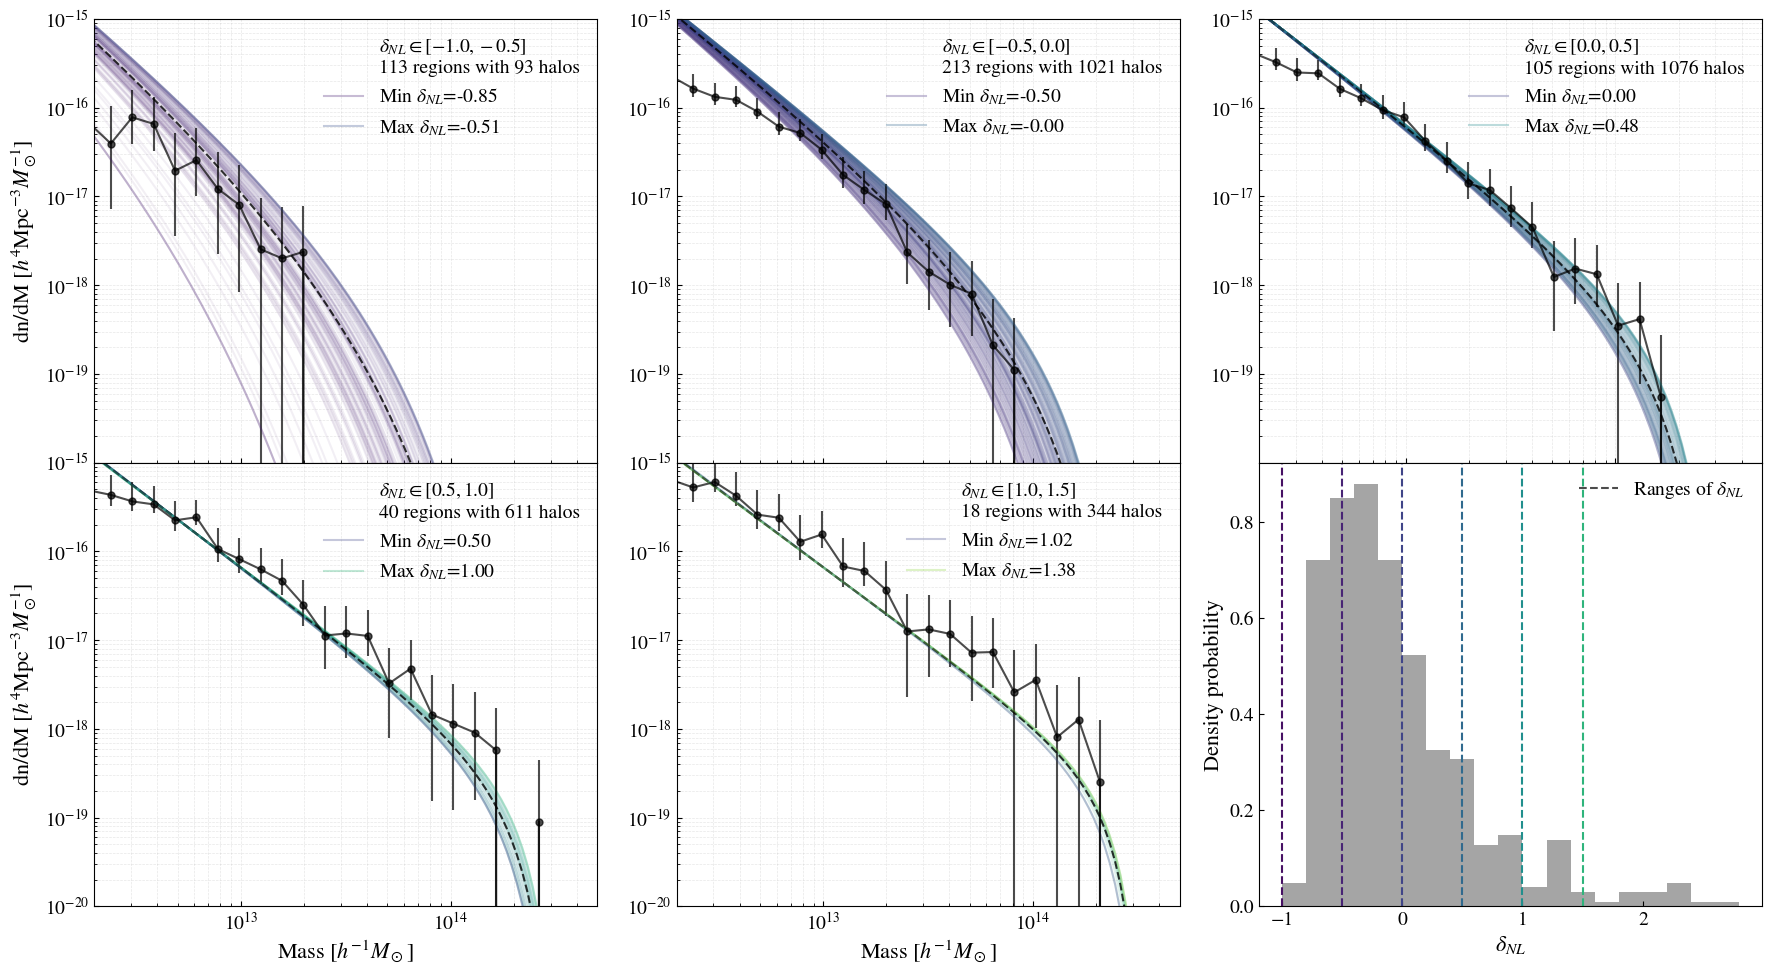

In [54]:
plot_every_sub_cmf2(subreg_sorted, arg_sub_cmf, delta_NL_paved, Ncut, mh, 50, M_list, shape = "sphere", z=zsnap, showfig=True, savename="./not_works_all_cmf.pdf")

# CMF with R0 not constant

In [55]:
# R0_list = np.linspace(1,100,50)
# ncST_R0_vary = []
# delta_NL_R0_vary = 1.26

In [56]:
# cmap = cm.viridis
# norm = plt.Normalize(vmin=0, vmax=np.max(R0_list))
# color = cmap(norm(R0_list))

# for idx,R0 in enumerate(R0_list) :
#     ncST_R0_vary.append([mycmf.cmfcalc(M_list[i], kh, pk, R0*h, mycmf.compute_delta_linear(delta_NL_R0_vary),delta_NL_R0_vary , model="QcST") for i in range(len(M_list))])
#     plt.loglog(M_list, ncST_R0_vary[-1], '-', color=color[idx],alpha=0.6)

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm)
# cbar.set_label(f'$R_0$ in Mpc')

# plt.xlim([2e12,5e15])
# plt.ylim([1e-22,1e-15])
# plt.xlabel(r"Mass $[h^{-1}M_\odot]$")
# plt.ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
# plt.title(f"$n_{{cST}}(\delta_{{NL}}={delta_NL_R0_vary:.2f})$ for different $R_0$")
# plt.legend()
# plt.show()

# fcoll

In [57]:
radius_sr_h = radius_sr * h #Mpc/h

In [58]:
hmf_over_bins = [mycmf.hmfcalc(bcen_hmf[i], kh, pk, "ST") for i in range(len(bcen_hmf))]
Mmin = mycmf.Mmin_finder(bcen_hmf, mydndm1_hmf, mydndm2_hmf, hmf_over_bins) #Msun/h

In [59]:
print(f"Mmin = {Mmin:.2e} Msun/h")

Mmin = 7.42e+12 Msun/h


In [88]:
Mmin/h/(mpart/2e30)

321.99405193065274

In [61]:
# Mmin=4e13

In [62]:
# mass_collapsed = np.array([np.sum(mh[sr.halo_indices]) for sr in subreg_sorted])*h
# mass_tot_in_sr = np.array([len((sr.part_indices).tolist())*mpart/2e30 for sr in subreg_sorted])*h
def compute_fcoll_emp(subreg_sorted, Mmin):
    '''
    Compute the fraction of collapsed mass in the subregions
    '''
    mass_collapsed = []
    mass_tot_in_sr = []
    delta_NL_filter = []
    for sr in subreg_sorted:
        if len(sr.halo_indices) > 0:
            mh_sr = mh[sr.halo_indices]
            mh_above_Mmin = mh_sr[mh_sr > Mmin/h]
            mcoll = np.sum(mh_above_Mmin)*h
            mtot = len((sr.part_indices).tolist())*mpart/2e30*h
            if mcoll > 0 and mtot > 0 and mtot > mcoll : 
                mass_collapsed.append(mcoll)
                mass_tot_in_sr.append(mtot)
                delta_NL_filter.append(sr.delta_NL)

    mass_collapsed = np.array(mass_collapsed)
    mass_tot_in_sr = np.array(mass_tot_in_sr)

    fcoll_emp = mass_collapsed / mass_tot_in_sr
    
    fcoll_emp = np.array(fcoll_emp)
    delta_NL_filter = np.array(delta_NL_filter)
    return fcoll_emp, delta_NL_filter

In [63]:
def compute_fcoll_th(subreg_sorted, Mmin):
    fcoll_th = []
    delta_NL_filter = []
    for idx, sr in enumerate(subreg_sorted):
        if len(sr.halo_indices) > 0 :
            mh_sr = mh[sr.halo_indices]
            mh_above_Mmin = mh_sr[mh_sr > Mmin/h]
            mcoll = np.sum(mh_above_Mmin)*h
            if mcoll > 0 :
                dL = sr.delta_L
                dNL = sr.delta_NL
                Mreg = len((sr.part_indices).tolist())*mpart/2e30 * h
                fcoll_val = mycmf.fcoll(Mmin, Mreg, kh, pk, radius_sr_h, dL, dNL, "QcST")
                if fcoll_val > 0 and fcoll_val < 1 :
                    fcoll_th.append(fcoll_val)
                    delta_NL_filter.append(sr.delta_NL)
                    print(f"{idx+1}/{len(subreg_sorted)} | Mmin {Mmin:.2e} | Mregion {Mreg:.2e} | R0={radius_sr_h:.2f} | delta_L {dL:.2f}, delta_NL {dNL:.2f} | fcoll_th = {fcoll_th[-1]:.3f}")
    
    fcoll_th = np.array(fcoll_th)
    delta_NL_filter = np.array(delta_NL_filter)
    
    return fcoll_th, delta_NL_filter

In [64]:
fcoll_emp, delta_NL_filter = compute_fcoll_emp(subreg_sorted, Mmin)

In [65]:
fcoll_th, delta_NL_filter = compute_fcoll_th(subreg_sorted, Mmin)

34/512 | Mmin 7.42e+12 | Mregion 1.24e+14 | R0=10.25 | delta_L -1.69, delta_NL -0.69 | fcoll_th = 0.003
38/512 | Mmin 7.42e+12 | Mregion 1.26e+14 | R0=10.25 | delta_L -1.65, delta_NL -0.68 | fcoll_th = 0.003
55/512 | Mmin 7.42e+12 | Mregion 1.38e+14 | R0=10.25 | delta_L -1.48, delta_NL -0.65 | fcoll_th = 0.005
68/512 | Mmin 7.42e+12 | Mregion 1.51e+14 | R0=10.25 | delta_L -1.31, delta_NL -0.62 | fcoll_th = 0.009
72/512 | Mmin 7.42e+12 | Mregion 1.54e+14 | R0=10.25 | delta_L -1.27, delta_NL -0.61 | fcoll_th = 0.010
75/512 | Mmin 7.42e+12 | Mregion 1.56e+14 | R0=10.25 | delta_L -1.25, delta_NL -0.61 | fcoll_th = 0.010
83/512 | Mmin 7.42e+12 | Mregion 1.62e+14 | R0=10.25 | delta_L -1.19, delta_NL -0.59 | fcoll_th = 0.012
86/512 | Mmin 7.42e+12 | Mregion 1.67e+14 | R0=10.25 | delta_L -1.13, delta_NL -0.58 | fcoll_th = 0.014
91/512 | Mmin 7.42e+12 | Mregion 1.76e+14 | R0=10.25 | delta_L -1.04, delta_NL -0.55 | fcoll_th = 0.017
94/512 | Mmin 7.42e+12 | Mregion 1.80e+14 | R0=10.25 | delta_L -

/tmp/ipykernel_1660058/3782268804.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


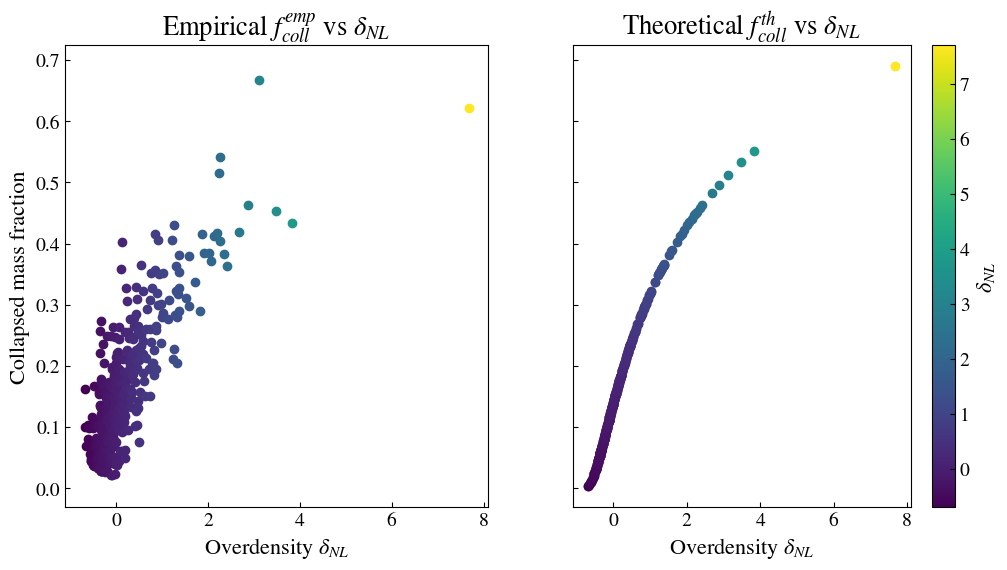

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

cmap = cm.viridis
norm = plt.Normalize(vmin=np.round(delta_NL_filter[0], 1), vmax=np.round(delta_NL_filter[-1], 1))
color = cmap(norm(delta_NL_filter))

for i in range(len(fcoll_emp)):
    ax[0].scatter(delta_NL_filter[i], fcoll_emp[i], color=color[i], alpha=1)
ax[0].set_xlabel(r"Overdensity $\delta_{NL}$")
ax[0].set_ylabel(r"Collapsed mass fraction")
ax[0].set_title(r"Empirical $f_{coll}^{emp}$ vs $\delta_{NL}$")

for i in range(len(delta_NL_filter)):
    ax[1].scatter(delta_NL_filter[i], fcoll_th[i], color=color[i], alpha=1)
ax[1].set_xlabel(r"Overdensity $\delta_{NL}$")
ax[1].set_title(r"Theoretical $f_{coll}^{th}$ vs $\delta_{NL}$")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.set_label(r'$\delta_{NL}$')

plt.show()

/tmp/ipykernel_1660058/3264457697.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


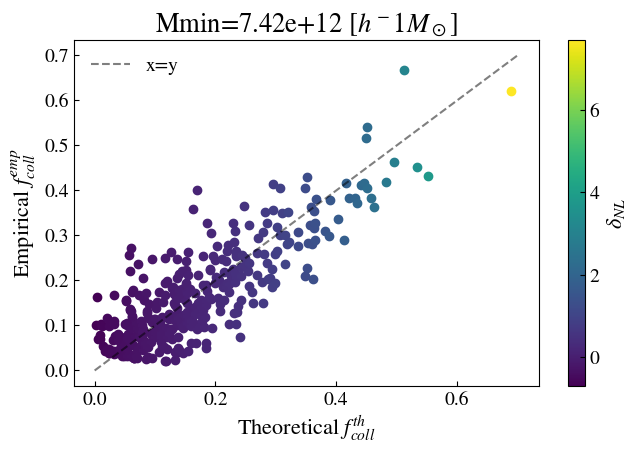

In [67]:
cmap = cm.viridis

norm = plt.Normalize(vmin=np.round(delta_NL_filter[0],1), vmax=np.round(delta_NL_filter[-1],1))
color = cmap(norm(delta_NL_filter))

plt.plot(np.linspace(0,0.7,100), np.linspace(0,0.7,100), '--', color="black", alpha=0.5, label="x=y")

for i in range(len(fcoll_emp)):
    plt.scatter(fcoll_th[i], fcoll_emp[i], color=color[i], alpha=1)

    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label(f'$\delta_{{NL}}$')

# plt.xlim(0, 0.7)
# plt.ylim(0,0.7)

plt.xlabel(r"Theoretical $f_{coll}^{th}$")
plt.ylabel(r"Empirical $f_{coll}^{emp}$")
plt.title(f"Mmin={Mmin:.2e} $[h^{-1}M_\odot]$")
plt.legend()
plt.show()

In [68]:
Mmin_range = np.logspace(np.log10(mh[-1]*h), 14, num=5)
print(Mmin_range)

[8.11461065e+11 2.70365184e+12 9.00811337e+12 3.00135192e+13
 1.00000000e+14]


In [69]:
Part_min = Mmin_range/h/(mpart/2e30)

In [87]:
Part_min

array([  35.20390347,  117.29348763,  390.80218053, 1302.08716093,
       4338.33550361])

In [70]:
# import pandas as pd


# fcoll_emp_range = []
# fcoll_th_range = []
# delta_NL_range = []
# diff_squared = []

# for i,Mmin in enumerate(Mmin_range) :
#     print(f"\n{i+1}/{len(Mmin_range)} | Mmin = {Mmin:.2e} Msun/h\n")
#     fcoll_emp, delta_NL_filter = compute_fcoll_emp(subreg_sorted, Mmin)
#     fcoll_th, delta_NL_filter = compute_fcoll_th(subreg_sorted, Mmin)
#     fcoll_emp_range.append(fcoll_emp)
#     fcoll_th_range.append(fcoll_th)
#     delta_NL_range.append(delta_NL_filter)
#     diff_squared.append(np.sum((fcoll_emp-fcoll_th)**2))
    

In [71]:
# df = pd.DataFrame({
#     "Mmin": Mmin_range,
#     "fcoll_emp": fcoll_emp_range,
#     "fcoll_th": fcoll_th_range,
#     "delta_NL": delta_NL_range,
#     "diff_squared": diff_squared
# })

# df.to_pickle("./saved_results/fcoll_comparison_th_emp.pkl")

In [72]:
# from matplotlib.colors import LogNorm

# cmap = cm.viridis
# # norm = plt.Normalize(vmin=Mmin_range[0], vmax=Mmin_range[-1])
# norm = LogNorm(vmin=np.min(Part_min), vmax=np.max(Part_min))
# color = cmap(norm(Part_min))

# # plt.plot(np.linspace(0,0.7,100), np.linspace(0,0.7,100), '--', color="black", alpha=0.5, label="x=y")

# for i in range(len(Mmin_range)):
#     plt.scatter(Part_min[i], diff_squared[i], color=color[i], alpha=1, label = f"Nb_part={int(Part_min[i])}")

    
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm)
# cbar.set_label(f'Nb_part')

# plt.xscale('log')

# plt.xlabel(r"Nb_part")
# plt.ylabel(r"Squared absolute difference")
# plt.title(r"Squared absolute difference of $f_{coll}^{emp}$ and $f_{coll}^{th}$ for different Mmin")
# plt.legend()
# plt.show()

In [73]:

# fig, ax = plt.subplots()

# cmap = cm.viridis
# norm = LogNorm(vmin=np.min(Part_min), vmax=np.max(Part_min))
# color = cmap(norm(Part_min))

# for i in range(len(Mmin_range)):
#     ax.scatter(Part_min[i], diff_squared[i], color=color[i], alpha=1, label=f"Nb_part={int(Part_min[i])}")

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Nb_part')

# ax.set_xscale('log')
# ax.set_xlabel(r"Nb_part")
# ax.set_ylabel(r"Squared absolute difference")
# # ax.set_title(r"Squared absolute difference of $f_{coll}^{emp}$ and $f_{coll}^{th}$ for different Mmin")


# def partmin_to_mmin(part):
#     return part * h * (mpart / 2e30)

# def mmin_to_partmin(mmin):
#     return mmin / h / (mpart / 2e30)


# secax = ax.secondary_xaxis('top', functions=(partmin_to_mmin, mmin_to_partmin))
# secax.set_xlabel(r"$M_{\min} \, [M_\odot]$")

# ax.legend()
# plt.show()

In [74]:
mh[-1]/(mpart/2e30)

35.20390347318998

### Fraction of the mass we miss

In [75]:
mh_below = mh[mh < Mmin/h]

mass_missed = np.sum(mh_below)/np.sum(mh)

print("Mass missed :",mass_missed*100,"% with ", len(mh_below), "halos out of ", len(mh), "halos. Ratio of halos missed to halos found is ", len(mh_below)/len(mh)*100, "%")

Mass missed : 17.40455453397556 % with  4561 halos out of  7084 halos. Ratio of halos missed to halos found is  64.3845285149633 %


### Plotting the subregion with the highest mass

In [76]:
subreg_sorted[-1].delta_NL

8.589046465099415

In [77]:
sr_highest_mass = subreg_sorted[-1]

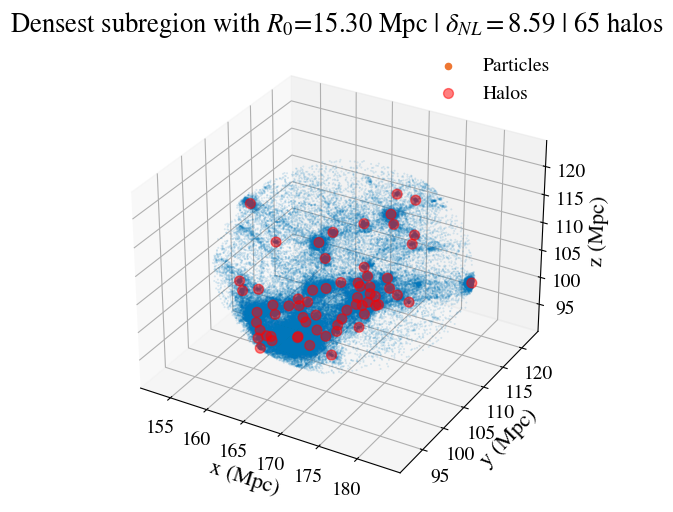

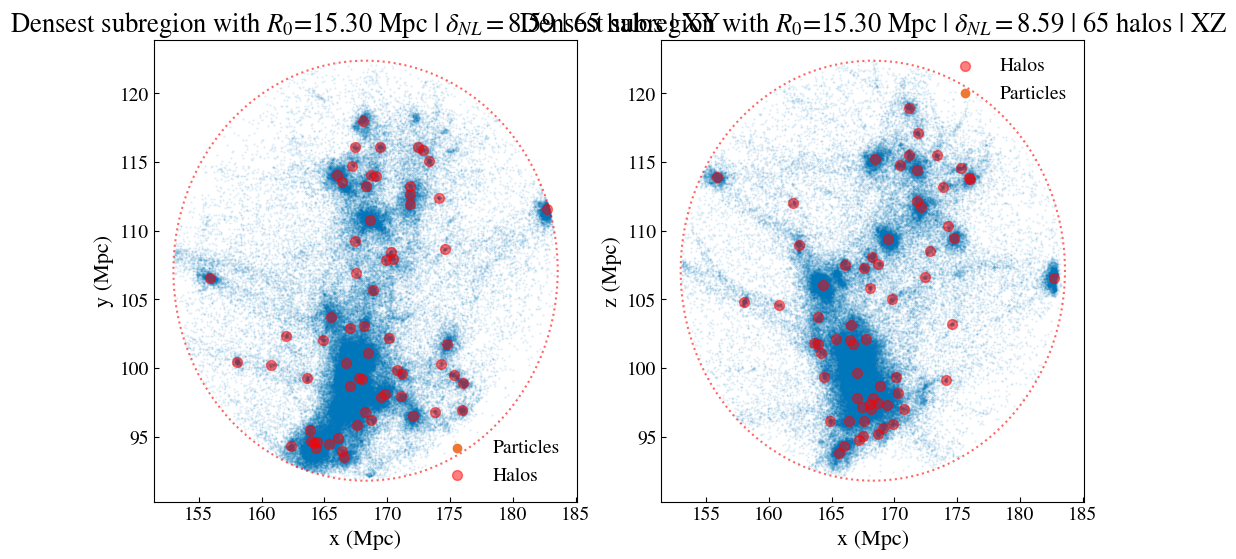

In [78]:
sr_highest_mass = subreg_sorted[-1]

idx_part_in_highest_mass_sr = sr_highest_mass.get_idx_particles_inside(part_pos_mpc)

idx_halo_in_highest_mass_sr = sr_highest_mass.get_idx_particles_inside(halo_pos_mpc)

part_alpha = 0.15
part_size = 0.2

halo_alpha = 0.5
halo_size = 50
halo_color = "red"

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.scatter(x_mpc[idx_part_in_highest_mass_sr], y_mpc[idx_part_in_highest_mass_sr], z_mpc[idx_part_in_highest_mass_sr], alpha=part_alpha, s=part_size)
ax.scatter([],[],[], label = "Particles")
ax.scatter(xh_mpc[idx_halo_in_highest_mass_sr], yh_mpc[idx_halo_in_highest_mass_sr], zh_mpc[idx_halo_in_highest_mass_sr], alpha=0.5, s=halo_size, color=halo_color, label = "Halos")
ax.set_xlabel("x (Mpc)")
ax.set_ylabel("y (Mpc)")
ax.set_zlabel("z (Mpc)")
ax.set_title(f"Densest subregion with $R_0$={radius_sr:.2f} Mpc | $\delta_{{NL}}={sr_highest_mass.delta_NL:.2f}$ | {len(idx_halo_in_highest_mass_sr)} halos")
ax.legend()

fig, (ax_xy, ax_xz) = plt.subplots(1, 2, figsize=(12, 6))

ax_xy.scatter(x_mpc[idx_part_in_highest_mass_sr], y_mpc[idx_part_in_highest_mass_sr], alpha=part_alpha, s=part_size)
ax_xy.scatter([],[], label = "Particles")
ax_xy.scatter(xh_mpc[idx_halo_in_highest_mass_sr], yh_mpc[idx_halo_in_highest_mass_sr], alpha=halo_alpha, s=halo_size, color=halo_color, label = "Halos")

if shape == "sphere":
    circle = plt.Circle((sr_highest_mass.center[0], sr_highest_mass.center[1]), radius_sr, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
    ax_xy.add_patch(circle)
elif shape == "cube":
    ax_xy.axvline(sr_highest_mass.center[0] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axvline(sr_highest_mass.center[0] + sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axhline(sr_highest_mass.center[1] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xy.axhline(sr_highest_mass.center[1] + sr_highest_mass.radius, color='r', linestyle='dotted')
    
ax_xy.set_xlabel("x (Mpc)")
ax_xy.set_ylabel("y (Mpc)")
ax_xy.set_title(f"Densest subregion with $R_0$={radius_sr:.2f} Mpc | $\delta_{{NL}}={sr_highest_mass.delta_NL:.2f}$ | {len(idx_halo_in_highest_mass_sr)} halos | XY")
ax_xy.legend()


ax_xz.scatter(x_mpc[idx_part_in_highest_mass_sr], z_mpc[idx_part_in_highest_mass_sr], alpha=part_alpha, s=part_size)
ax_xz.scatter(xh_mpc[idx_halo_in_highest_mass_sr], zh_mpc[idx_halo_in_highest_mass_sr], alpha=halo_alpha, s=halo_size, color=halo_color, label = "Halos")
ax_xz.scatter([],[], label = "Particles")
if shape == "sphere":
    circle = plt.Circle((sr_highest_mass.center[0], sr_highest_mass.center[2]), radius_sr, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
    ax_xz.add_patch(circle)
elif shape == "cube":
    ax_xz.axvline(sr_highest_mass.center[0] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xz.axvline(sr_highest_mass.center[0] + sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xz.axhline(sr_highest_mass.center[1] - sr_highest_mass.radius, color='r', linestyle='dotted')
    ax_xz.axhline(sr_highest_mass.center[1] + sr_highest_mass.radius, color='r', linestyle='dotted')
ax_xz.set_xlabel("x (Mpc)")
ax_xz.set_ylabel("z (Mpc)")
ax_xz.set_title(f"Densest subregion with $R_0$={radius_sr:.2f} Mpc | $\delta_{{NL}}={sr_highest_mass.delta_NL:.2f}$ | {len(idx_halo_in_highest_mass_sr)} halos | XZ")
ax_xz.legend()

plt.show()

In [79]:
mh[idx_halo_in_highest_mass_sr]

array([1.82663519e+15, 3.39429492e+14, 1.44817252e+14, 1.28864862e+14,
       1.27411499e+14, 7.48828036e+13, 6.23908017e+13, 5.92418483e+13,
       5.75808619e+13, 4.47774251e+13, 3.98982775e+13, 3.77182329e+13,
       3.74760057e+13, 3.53997727e+13, 3.29428970e+13, 3.20085921e+13,
       2.75100873e+13, 2.73716717e+13, 2.64027630e+13, 2.63335552e+13,
       2.47417766e+13, 2.23541087e+13, 1.93089669e+13, 1.81670388e+13,
       1.74057533e+13, 1.69905067e+13, 1.41875922e+13, 1.29072485e+13,
       1.26650213e+13, 1.17307165e+13, 1.13500737e+13, 1.02427495e+13,
       9.55067181e+12, 8.78938637e+12, 8.51255531e+12, 7.88968541e+12,
       7.82047764e+12, 7.26681551e+12, 5.91726405e+12, 5.05216697e+12,
       4.80993979e+12, 4.77533590e+12, 4.70612814e+12, 4.36008930e+12,
       4.22167377e+12, 4.22167377e+12, 4.11786212e+12, 4.04865435e+12,
       3.56419999e+12, 3.49499222e+12, 3.39118057e+12, 3.32197280e+12,
       3.28736892e+12, 3.21816115e+12, 3.07974562e+12, 3.04514174e+12,
      

# R200

In [80]:
def linear_overdensity(center_sphere, radius_sphere, grid_size, part_pos_mpc,  rho_mean):
    rho = density_in_shape(center_sphere, radius_sphere, grid_size, part_pos_mpc)
    delta_NL = rho / rho_mean
    delta_L = mycmf.compute_delta_linear(delta_NL)
    return delta_L

def compute_dist_from_center(center_sphere, grid_size, pos_mpc):
    cx, cy, cz = center_sphere
    x, y, z = pos_mpc[:,0], pos_mpc[:,1], pos_mpc[:,2]
    xsize, ysize, zsize = grid_size
    
    dx = np.minimum(abs(x - cx), xsize - abs(x - cx)) #either normal distance or substracting the grid_size 
    dy = np.minimum(abs(y - cy), ysize - abs(y - cy))
    dz = np.minimum(abs(z - cz), zsize - abs(z - cz))
    
    d = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    
    return d

In [81]:
def compute_R200_mine(halo_idx, R200_init, grid_size, part_pos_mpc, rho_mean, print_convergence = True):
    halo_pos = [xh_mpc[halo_idx], yh_mpc[halo_idx], zh_mpc[halo_idx]]
    halo_mass = mh[halo_idx] #Msun
    R200 = R200_init #Mpc
    R200_max = R200
    R200_min = 1e-3

    parts_in_halo = idx_of_part_in_shape(halo_pos, R200, grid_size, part_pos_mpc)
    delta_L = linear_overdensity(halo_pos, R200, grid_size, part_pos_mpc, rho_mean)
    print(f"Computing the R200 of the halo of center {np.round(halo_pos,0)} and mass {halo_mass:.2e} Msun...")
    
    while abs(delta_L - 200) > 5e-2:
        if print_convergence:
            print(f"Current overdensity of {delta_L:.2f} with a R200 = {R200:.2f} Mpc and with {len(parts_in_halo)} particles in it.")
        # R200= R200 / 2
        if delta_L < 200:
            R200_max = R200
        else:
            R200_min = R200
        
        R200 = (R200_max + R200_min) / 2  

        parts_in_halo = idx_of_part_in_shape(halo_pos, R200, grid_size, part_pos_mpc)
        delta_L = linear_overdensity(halo_pos, R200, grid_size, part_pos_mpc, rho_mean)
    print(f"Convergence over ! Overdensity of : {delta_L:.1f}.")
    print(f"Halo of center {np.round(halo_pos,0)} and mass {halo_mass:.2e} Msun has a R200 of {R200:.2f} Mpc with {len(parts_in_halo)} particles in it.")
    return R200

In [82]:
def compute_R200(halo_idx, R200_init, grid_size, part_pos_mpc, rho_mean, mpart=mpart):
    halo_pos = [xh_mpc[halo_idx], yh_mpc[halo_idx], zh_mpc[halo_idx]]
    nb_part_init = idx_of_part_in_shape(halo_pos, R200_init, grid_size, part_pos_mpc)
    
    ri = compute_dist_from_center(halo_pos, grid_size, part_pos_mpc[nb_part_init])
    ri_sorted = np.sort(ri)
    
    N = np.array([i for i in range(1,len(nb_part_init)+1)])
    
    rho_region = mpart/2e30 * N / (4/3*np.pi*ri_sorted**3)
    rho_quotient = rho_region / rho_mean
    
    below_200 = np.where(rho_quotient < 200)[0]
    
    if len(below_200) == 0 :
        print("No R200 found with this R200_init, increasing R200_init...")
        R200 = compute_R200(halo_idx, 2*R200_init, grid_size, part_pos_mpc, rho_mean, mpart=mpart)
        return R200
    
    R200 = ri_sorted[below_200[0]]
    
    return R200

In [83]:
halo_of_interest = 0
R200init = 10 #Mpc
halo_center = [xh_mpc[halo_of_interest], yh_mpc[halo_of_interest], zh_mpc[halo_of_interest]]

R200test = compute_R200(halo_of_interest, R200init, grid_size, part_pos_mpc, rho_MsunMpc3)

In [84]:
print(compute_R200(halo_of_interest, R200init, grid_size, part_pos_mpc, rho_MsunMpc3))

4.4013968


In [85]:
# print(compute_R200_mine(halo_of_interest, R200init, grid_size, part_pos_mpc, rho_MsunMpc3,print_convergence=False))

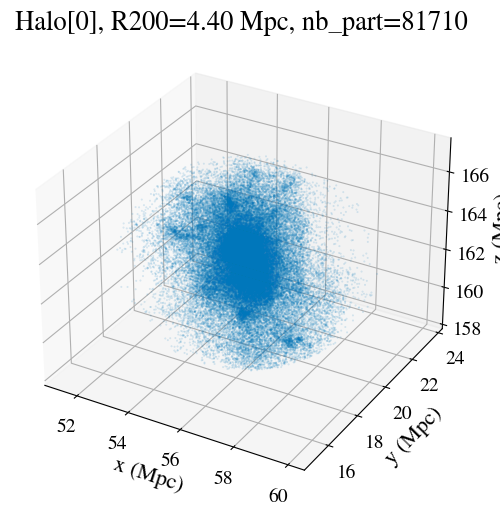

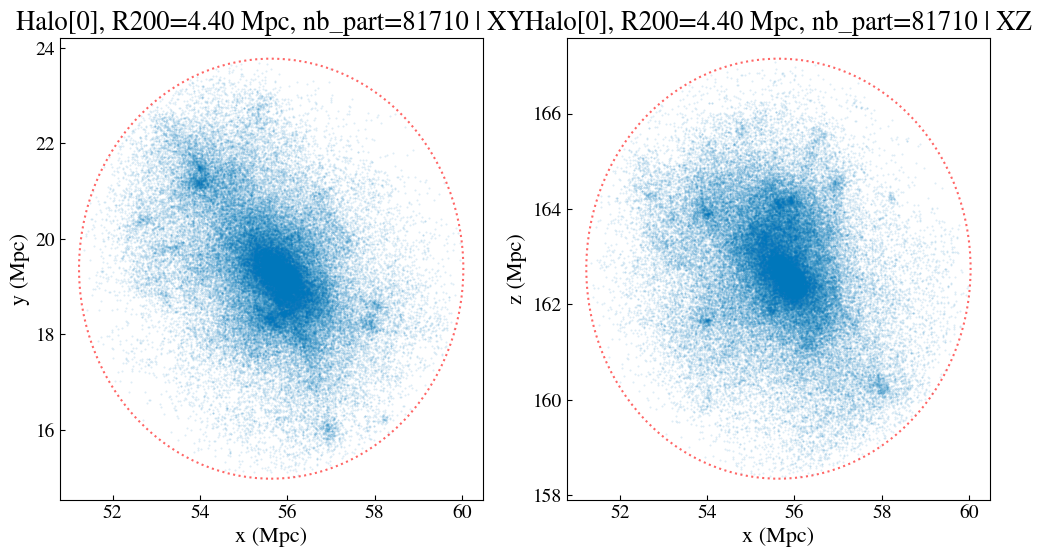

In [86]:
idx_part_in_HOI = idx_of_part_in_shape(halo_center, R200test, grid_size, part_pos_mpc)
part_alpha = 0.15
part_size = 0.2


fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.scatter(x_mpc[idx_part_in_HOI], y_mpc[idx_part_in_HOI], z_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
ax.set_xlabel("x (Mpc)")
ax.set_ylabel("y (Mpc)")
ax.set_zlabel("z (Mpc)")
ax.set_title(f"Halo[{halo_of_interest}], R200={R200test:.2f} Mpc, nb_part={len(idx_part_in_HOI)}")

fig, (ax_xy, ax_xz) = plt.subplots(1, 2, figsize=(12, 6))

ax_xy.scatter(x_mpc[idx_part_in_HOI], y_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
circle = plt.Circle((halo_center[0], halo_center[1]), R200test, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
ax_xy.add_patch(circle)
ax_xy.set_xlabel("x (Mpc)")
ax_xy.set_ylabel("y (Mpc)")
ax_xy.set_title(f"Halo[{halo_of_interest}], R200={R200test:.2f} Mpc, nb_part={len(idx_part_in_HOI)} | XY")

ax_xz.scatter(x_mpc[idx_part_in_HOI], z_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
circle = plt.Circle((halo_center[0], halo_center[2]), R200test, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
ax_xz.add_patch(circle)
ax_xz.set_xlabel("x (Mpc)")
ax_xz.set_ylabel("z (Mpc)")
ax_xz.set_title(f"Halo[{halo_of_interest}], R200={R200test:.2f} Mpc, nb_part={len(idx_part_in_HOI)} | XZ")

plt.show()